In [ ]:
# colab 사용 시! Local PC로 실습하는 경우 실행 x / 단, 작업경로를 2025_LGE_SSL로 맞춰주기

!git clone https://github.com/Im-JihyunKim/2025_LG_ES_SSL.git
%cd /content/2025_LG_ES_SSL

In [1]:
# !pip install IPython
from IPython.display import Image

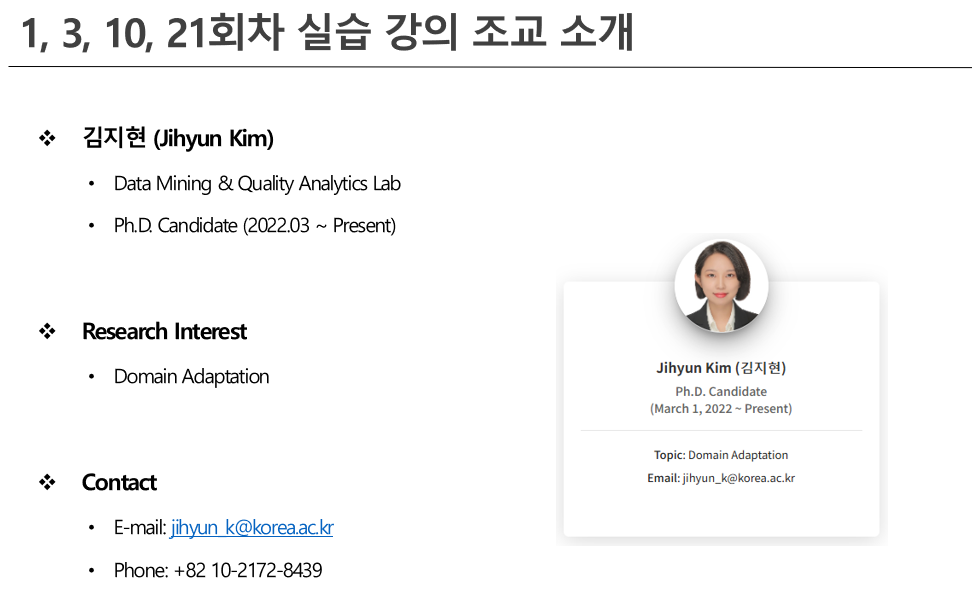

In [2]:
Image('./images/img0.png')

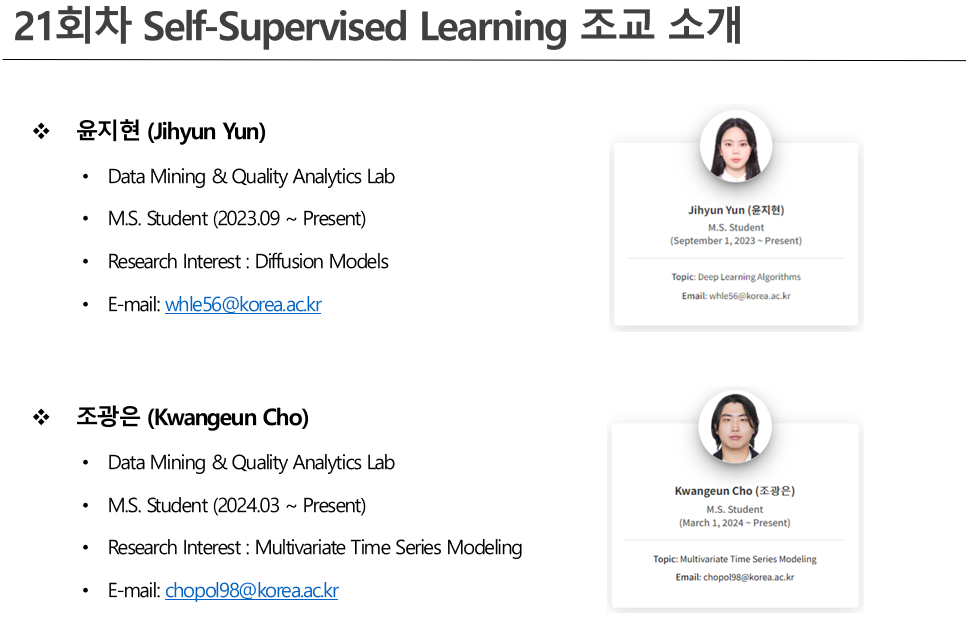

In [3]:
Image('./images/assist.png')

------

## Task: Self-supervised Learning - Contrastive Learning

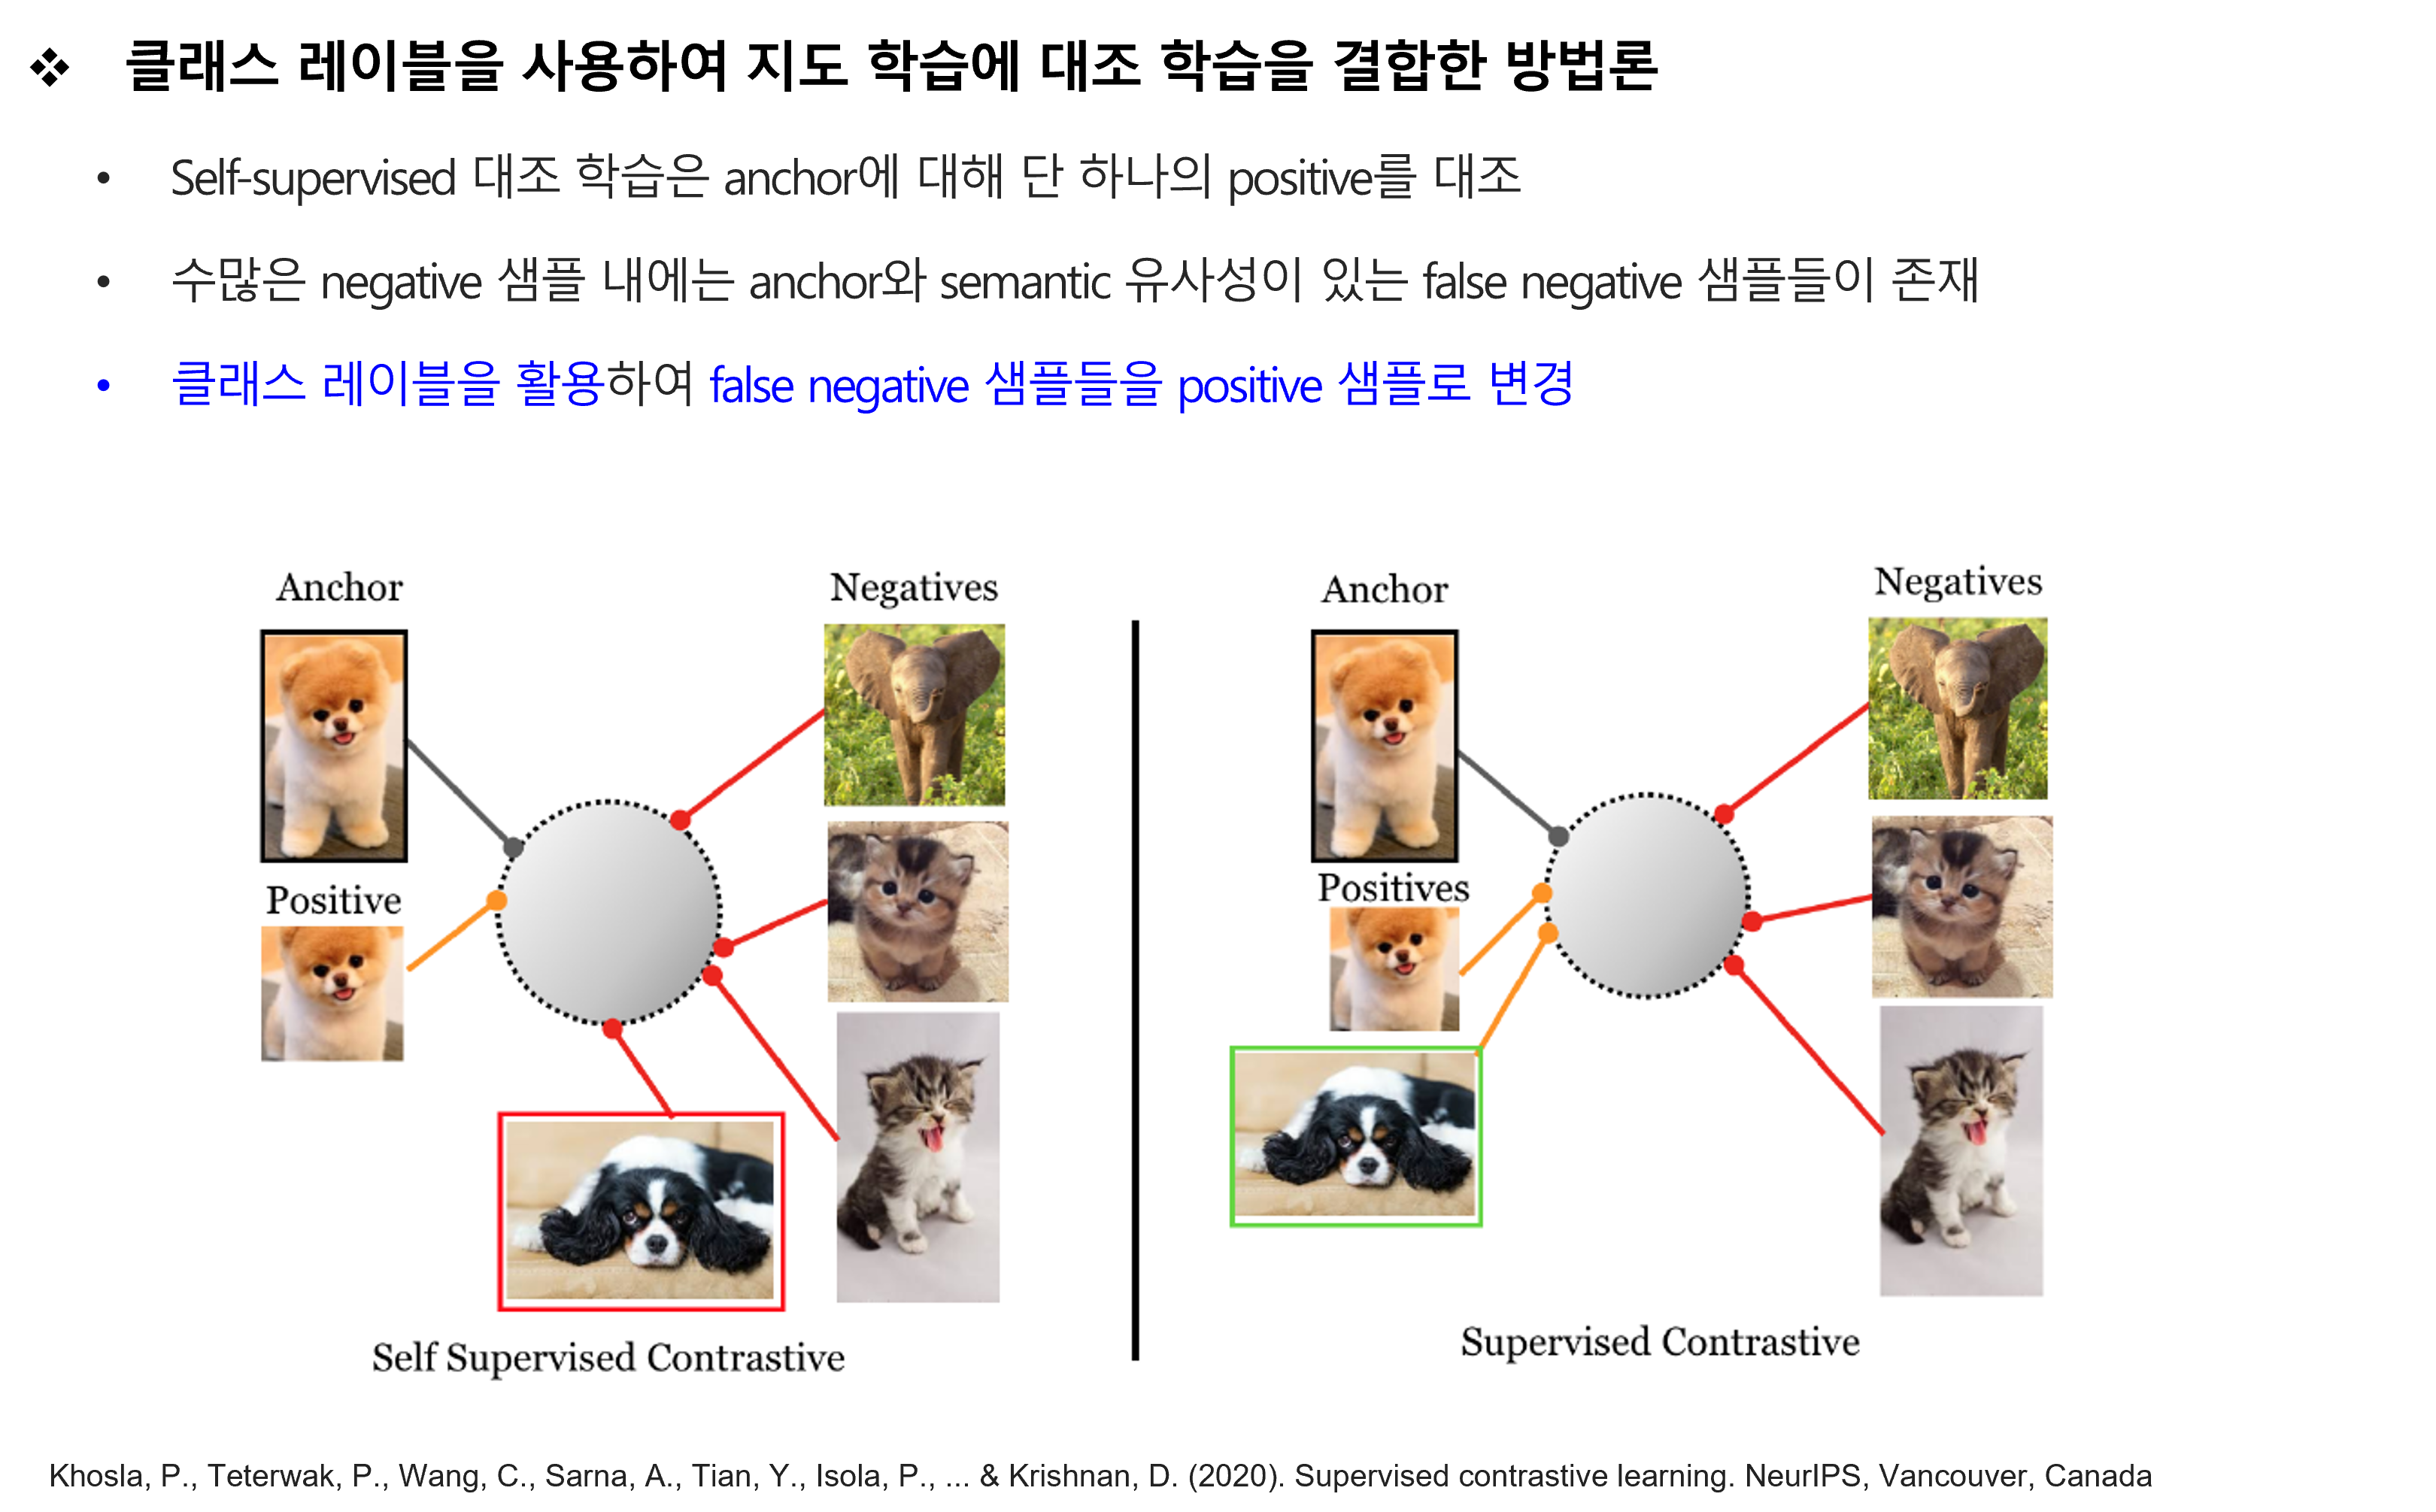

In [3]:
Image('images/contrastive.png')

### Self Supervised Contrastive - **SimCLR**

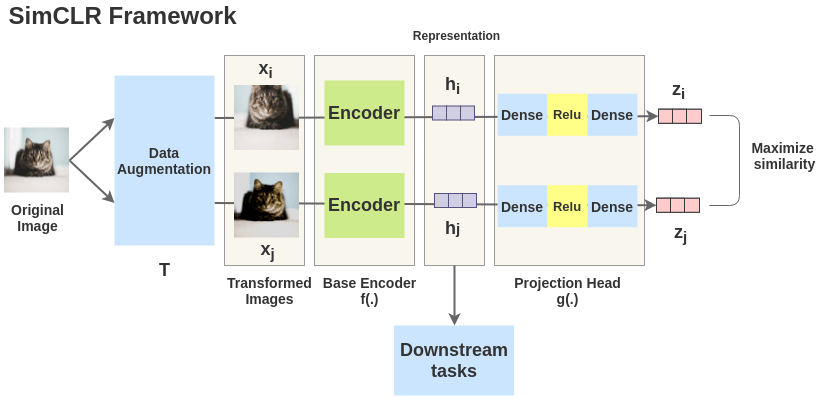

In [2]:
""" 설명 장표 불러오기 """
Image('images/simclr.PNG')

### Supervised Contrastive - **SupCon**
- Label (y; Class/Target) 정보가 있을 때 사용하는 방법론!

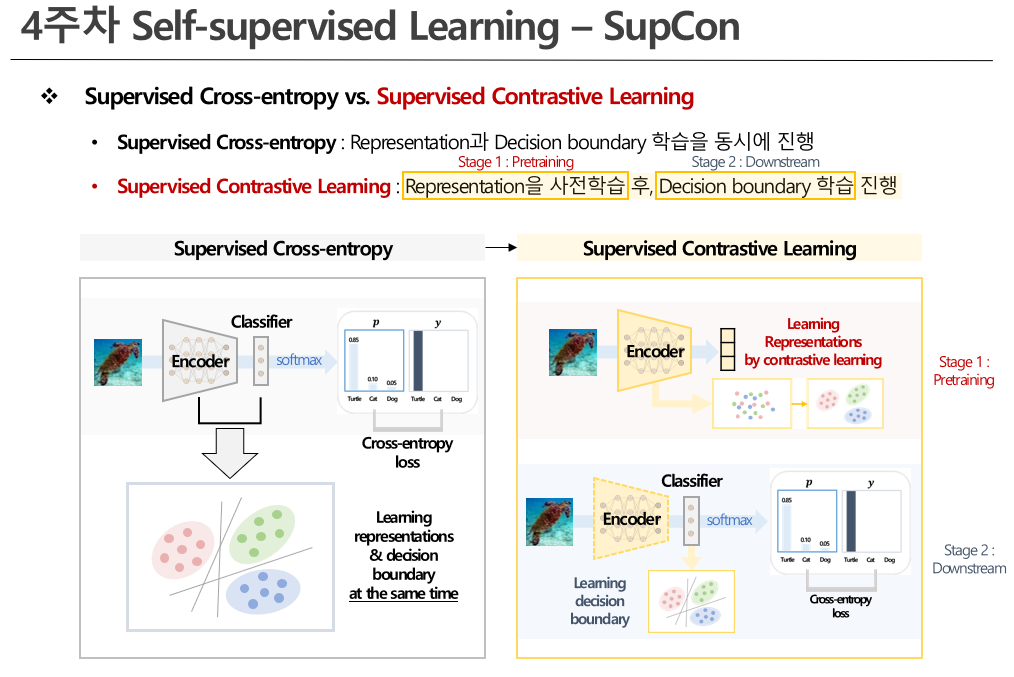

In [ ]:
Image('images/whysupcon.PNG')

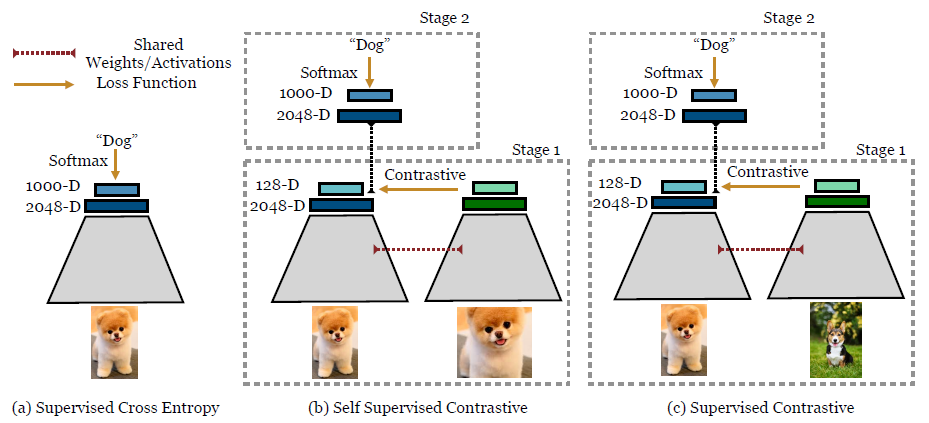

In [ ]:
Image('images/whysupcon2.PNG')

#### 질문. 왜 Supervised Learning 대신 Supervised Contrastive Learning을 사용할까?
- 성능 향상: 더 풍부한 정보를 가진 representation 획득 가능, class 간 구분을 더욱 명확히 만듦
    - 더불어, 전통적인 cross entropy loss와 달리, 각 샘플을 개별적으로 고려하기에 불균형 class를 가진 데이터셋에서 더 나은 성능을 가질 수 있음
- 하이퍼파라미터에 덜 민감
- 레이블 데이터가 적을 때도 효과적인 학습 가능
- 멀티 모달, 다중 클래스 레이블 등의 조건에서 우수한 성능 가능

## 1. 필요 라이브러리 호출

In [2]:
import os, random, time
import numpy as np
from sklearn.model_selection import train_test_split

import torch
import torchvision
import torch.nn as nn 
import torch.nn.functional as F 
import torchvision.models as models 
from torch.utils.data import Dataset, DataLoader, Subset 
from torchvision.transforms import transforms
from torchvision import transforms, datasets

import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
import seaborn as sns

import warnings
warnings.filterwarnings(action='ignore')

<Figure size 640x480 with 0 Axes>

## 2. Dataset 및 Dataloader 정의

### 실습 데이터셋: CIFAR10
- 32x32의 RGB 이미지로 구성된 데이터셋
- 10개의 class를 분류하는 image classification task에 주로 활용

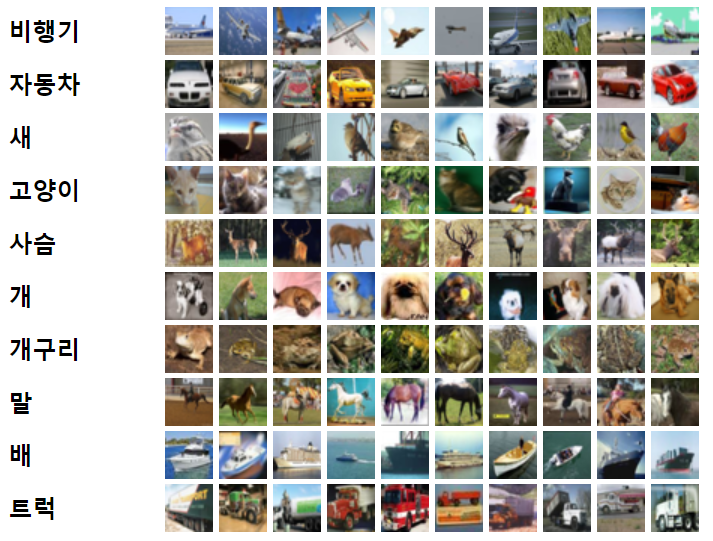

In [9]:
Image('images/7-CIFAR101.PNG')

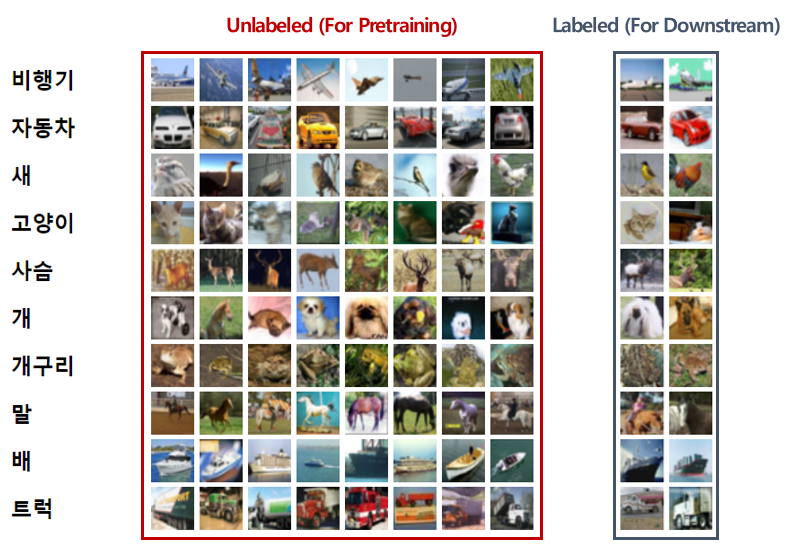

In [ ]:
Image('images/7-CIFAR102.PNG')

  - 총 60,000개의 데이터가 있으며 일반적으로 50,000개는 학습용, 10,000개는 테스트용으로 구분해서 사용
  - 본 튜토리얼에서는 50,000개의 학습용 이미지를 Pretraining Task에서, 10,000개의 테스트용 이미지를 Downstream Task에 활용
    - 10,000개의 Downstream Task용 이미지는 8,000개의 Train과 2,000개의 Test 데이터로 구분됨 (Validation Dataset은 별도로 구분하지 않음)

In [3]:
class CIFAR10Dataset(Dataset):
    def __init__(self, configs:dict, aug_generator:object):
        self.configs = configs
        self.data_dir = configs['data_dir']
        self.aug_generator = aug_generator

        # 저장 경로 폴더가 없는 경우 만들어주어야 함
        os.makedirs(self.data_dir, exist_ok=True)

    """For Pretraining Task : 사전학습 시 사용되는 데이터셋"""
    def get_pretrain_dataset(self, n_views: int=2):
        pretrain_dataset = datasets.CIFAR10(self.data_dir, 
                                            train=True,  # train 여부
                                            transform=self.aug_generator(   # 사전에 정의한 augmented images generator 기반으로 transform 수행
                                                    base_transform=self.get_transform(),  # 사전에 정의한 이미지 변형 방법 적용
                                                    n_views=n_views),  # view는 하나의 동일한 이미지를 다른 시각으로 본다는 의미로, number of views 만큼 augmentation 수행
                                            download=True)
        return pretrain_dataset
    
    """For Downstream Task : Downstream 지도학습에 사용되는 데이터"""
    def get_dataset(self, mode: str='train'):
        downstream_dataset = datasets.CIFAR10(self.data_dir,
                                             train=False,   # train 여부
                                             transform=transforms.Compose([
                                                        transforms.ToTensor(),    # 이미지를 tensor 타입으로 바꾸어줌
                                                        transforms.Normalize(      # 이미지 데이터 내의 값을 정규화 (역전파 단계에서 gradient 계산 시 데이터마다 유사한 범위의 값을 가지도록 하기 위함)
                                                                mean=(0.4914, 0.4822, 0.4465),
                                                                std=(0.2023, 0.1994, 0.2010))
                                                                ]),
                                             download=True)
        
        train_idx, test_idx = train_test_split(list(range(len(downstream_dataset))), 
                                               test_size=0.2,
                                               random_state=self.configs['seed'])

        if mode == 'train':
            train_dataset = Subset(downstream_dataset, train_idx)  # 8,000개
            return train_dataset
        
        elif mode == 'test':
            test_dataset = Subset(downstream_dataset, test_idx)    # 2,000개
            return test_dataset
        
        else:
            raise NotImplementedError("'mode' should be one of ['train' or 'test']")
        
    @staticmethod  # 해당 클래스에서만 사용되는 메소드
    def get_transform(s:float=.5):
        """
        Return a set of data augmentation transformations 
        as described in the SimCLR paper.
        - i.e., 'random crop and resize', 'color distortion', and 'blur'.
        """
        # 이미지 데이터 내의 값을 정규화
        ## gradient 역전파 과정에서 중요 (큰 값은 activation function 출력 값을 포화 영역에 다다르게 함 -> 미분 값이 작아짐 -> 기울기 소실)
        ## 작은 범위의 값으로 학습 안전성 확보
        ## 더불어 RGB 채널 중 특정 채널에 가중이 크게 치우치는 것을 방지 (스케일 차이로 인하여) (모든 색상 정보를 균등하게 고려)

        # normalized = (original - mean) / std.   # Standardization
        # CIFAR-10에 특화된 normalize!!
        normalize = transforms.Normalize( 
            mean=(0.4914, 0.4822, 0.4465),  # R, G, B 채널 평균 값
            std=(0.2023, 0.1994, 0.2010)    # R, G, B 채널의 표준편차
        )

        # s is the strength of color distortion (0.5 for CIFAR10 by default)
        color_jitter = transforms.ColorJitter(0.8*s, 
                                              0.8*s,
                                              0.8*s,
                                              0.2*s)
        
        # See Section B.9 of SimCLR: https://arxiv.org/abs/2002.05709
        data_transforms = transforms.Compose([
            transforms.RandomResizedCrop(size=32),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomApply([color_jitter], p=0.8),
            transforms.RandomGrayscale(p=0.2),
            transforms.ToTensor(),  # 이미지 데이터 텐서화
            normalize,              # 앞서 정의한 이미지 정규화 수행
        ])

        return data_transforms

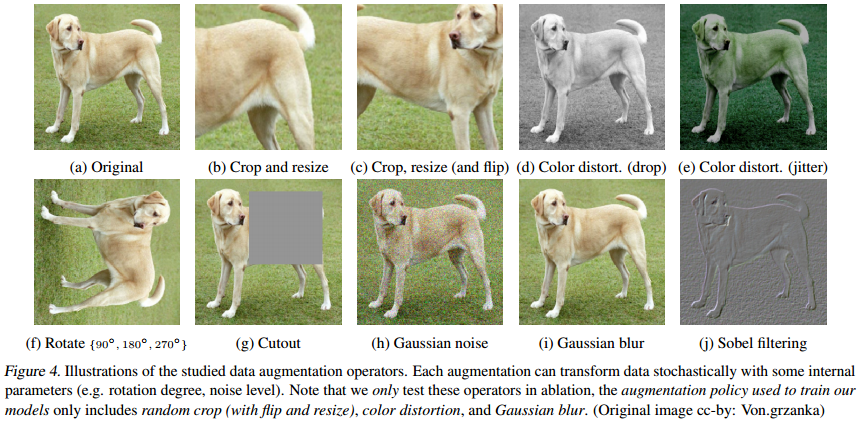

In [20]:
Image('images/SimCLR_aug.PNG')

In [4]:
"""사전에 정의한 transform 방식을 기반으로 증강된 이미지를 반환해주는 class"""
class aug_generator(object):
    """
    Take 2 random crops of one image as the query and key.
    """
    def __init__(self, base_transform, n_views: int=2):
        self.base_transform = base_transform
        self.n_views = n_views

    def __call__(self, x):  # aug_generator 클래스 호출 시 수행되는 함수
        return [self.base_transform(x) for i in range(self.n_views)]  # n_views 만큼 base_transform(get_transform 메소드에서 정의된 증강기법)을 수행하라

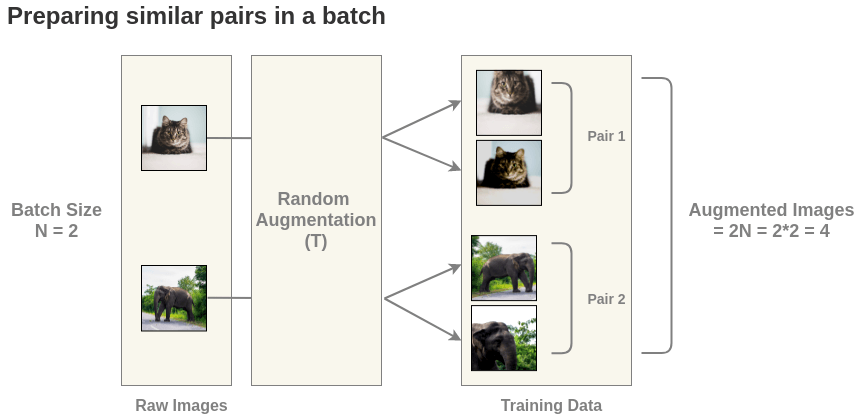

In [24]:
Image('./images/simclr-batch-data-preparation.PNG')

Files already downloaded and verified


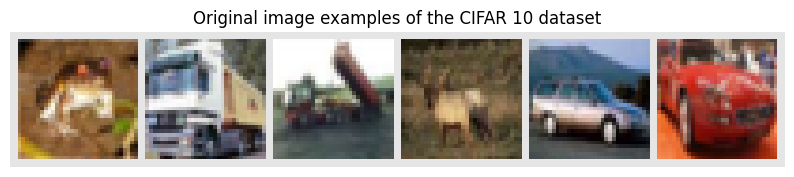

Files already downloaded and verified


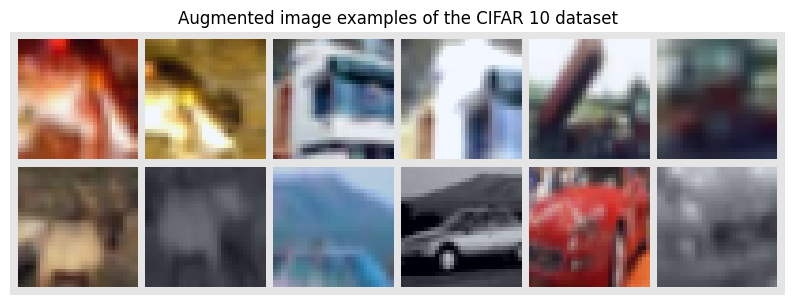

In [5]:
""" 실제 CIFAR10이미지와 증강된 CIFAR10이미지 비교 """
##### Original CIFAR10 이미지 #####
data_dir = './data/'

### 데이터셋 불러오기
Cifar10_original = datasets.CIFAR10(root=data_dir, train=True, download=True, transform=transforms.ToTensor())
imgs = torch.stack([Cifar10_original[idx][0] for idx in range(6)], dim=0)
img_grid = torchvision.utils.make_grid(imgs, nrow=6, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

### 시각화
plt.figure(figsize=(10, 5))
plt.title('Original image examples of the CIFAR 10 dataset')
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()


##### 증강된 CIFAR10 이미지 #####
### 데이터셋 불러오기
data_configs = {'data_dir':data_dir}
Cifar10 = CIFAR10Dataset(data_configs, aug_generator)
Cifar10_aug_dataset = Cifar10.get_pretrain_dataset()
imgs = torch.stack([img for idx in range(6) for img in Cifar10_aug_dataset[idx][0]], dim=0)
img_grid = torchvision.utils.make_grid(imgs, nrow=6, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

### 시각화
plt.figure(figsize=(10, 5))
plt.title('Augmented image examples of the CIFAR 10 dataset')
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

--------

## 3. SimCLR 모델 정의

### Encoder (ResNet)
- Each augmented image in a pair is passed through an encoder to get image representations.
- The encoder used is generic and replaceable with other architectures.  

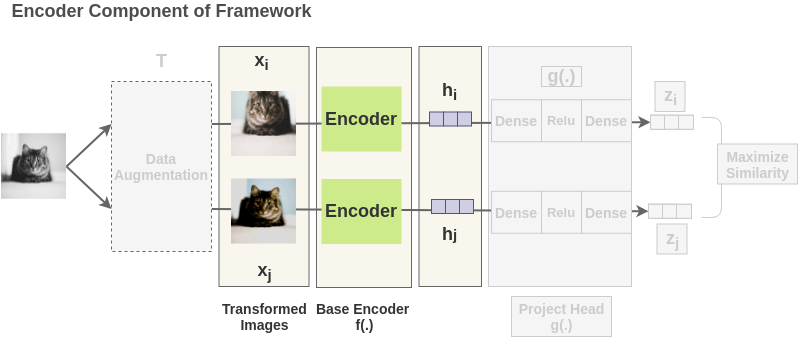

In [25]:
Image('./images/simclr-encoder.PNG')

### Encoder (ResNet)
```bash
- We will Customize encoder for CIFAR10! 
    - Replace conv 7x7 with conv 3x3, and remove first max pooling 
    - It is because CIFAR-10 images are much smaller that ImageNet images. 
```
- cf. ResNet은 ImageNet dataset을 기준으로 짜인 모델  
    - CIFAR-10: 32x32 vs. ImageNet : 224x224 이상  
    - CIFAR-10의 작은 이미지에서는 7x7 kernel이 너무 큰 receptive field를 가짐  
        - 즉, 작은 이미지의 거의 모든 영역을 봄에 따라 정보를 과도하게 압축하거나 local한 정보를 놓칠 수 있음.  
        - 32x32 크기에 7x7 kernel을 이용하면 첫 번쨰 layer에서만 이미지의 약 22%를 한 번에 보게 됨  
    - 작은 receptive field로도 충분한 특징을 추출할 수 있기에 비효율적 (불필요한 계산)    
    - 더불어 max pooling은 ImageNet과 같이 큰 이미지 차원을 줄이기 위해 사용되는데, CIFAR-10과 같이 작은 이미지에서 pooling을 이용하면 너무 많은 정보가 손실될 우려가 있음

### Projector (MLP)
- The representations $h_i$ and $h_j$ of the two augmented images are then passed through a series of non-linear **Dense->ReLU->Dense** layers to apply non-linear transformation
- Then, project it into a representation $z_i$ and $z_j$.

##### 질문. 왜 Projection이 필요할까?
1. $Z$가 $H$보다 낮은 랭크를 가지도록 하기 위함 
    - 즉, $H$에 비해 더 낮은 차원에 투영하여 몇몇 주요 특징으로 압축
    - 이로써 contrastive learning을 최적화하는 데 더 도움이 되는 중요한 특징들만 남기고 불필요한 변동성은 제거
2. Feature collapse 방지를 위함
    - 모델이 다양한 입력 데이터에 대해 거의 동일한 또는 매우 유사한 특징 벡터를 출력하는 경우

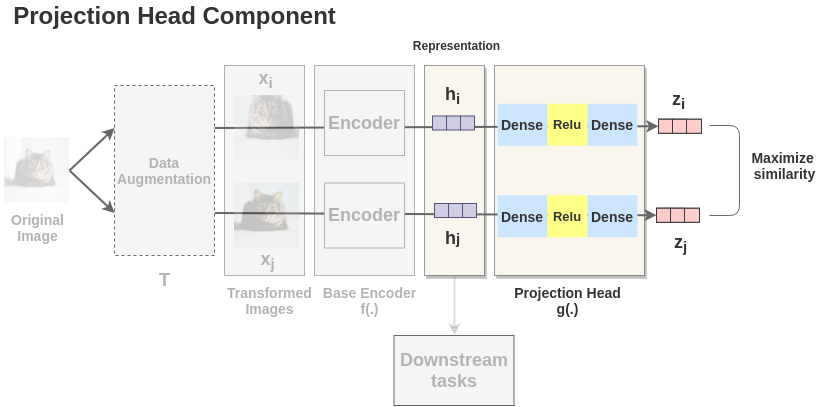

In [26]:
Image('./images/simclr-projection.PNG')

In [6]:
class SimCLR(nn.Module):
    def __init__(self, configs):
        super(SimCLR, self).__init__()
        self.configs = configs
        self.device = configs['device']

        self.backbone = configs['backbone']
        self.hidden_dim = configs['hidden_dim']
        self.projection_dim = configs['projection_dim']

        ## Base encoder 선정
        # load model from torchvision.models without pretrained weights.
        resnet_dict = {
            'resnet18': models.resnet18(pretrained=False),   
            'resnet50': models.resnet50(pretrained=False)
        }
        self.encoder = resnet_dict[self.backbone]

        # Customize for CIFAR10. Replace conv 7z7 with conv 3x3, and remove first max pooling
        self.encoder.conv1 = nn.Conv2d(in_channels=3,
                                       out_channels=64, 
                                       kernel_size=3, 
                                       stride=1, 
                                       padding=1, 
                                       bias=False)
        
        self.encoder.maxpool = nn.Identity()  # 입력과 동일한 tensor를 출력으로 내보내주는 layer

        """get feature dim from in_features in fc-layer for resnet18 in torchvision"""
        feature_dim = self.encoder.fc.in_features  # resnet18.fc.in_features=256
        self.encoder.fc = nn.Identity()  # remove final fully connected layer

        # Add MLP projection
        self.projector = nn.Sequential(
            nn.Linear(feature_dim, self.hidden_dim), 
            nn.ReLU(),
            nn.Linear(self.hidden_dim, self.projection_dim)
        )

    def forward(self, x):
        representation = self.encoder(x)
        projection = self.projector(representation)

        logits, labels = self.nt_xent(projection, n_views=2)

        return logits, labels
    
    def nt_xent(self, Z, n_views:int=2):
        ### Label Index 정렬: Augmentation 횟수를 고려하여 짝짓기
        batch_size = Z.size(0)//n_views
        labels = torch.cat([torch.arange(batch_size) for _ in range(n_views)], dim=0)
        
        # Positive는 1, Negative는 0으로 (True False를 float 형태로 나타내는 것)
        labels = (labels.unsqueeze(0) == labels.unsqueeze(1)).float()
        labels = labels.to(self.device)

        # 벡터를 L2 정규화 후 내적 = 코사인 유사도
        Z = F.normalize(Z, p=2, dim=1)
        similarity_matrix = torch.matmul(Z, Z.T)

        # 자기 자신과 관련된 연산은 제거
        # -> labels matrix, similarity matrix에서 main diagonal 지우기
        mask = torch.eye(labels.size(0), dtype=torch.bool).to(self.device)  # 대각 성분만 True
        labels = labels[~mask].view(labels.size(0), -1)
        similarity_matrix = similarity_matrix[~mask].view(similarity_matrix.size(0), -1)

        # Select and combine multiple positives
        positives = similarity_matrix[labels.bool()].view(labels.size(0), -1)
        # Select only the negatives
        negatives = similarity_matrix[~labels.bool()].view(labels.size(0), -1)

        # logits 값, labels 값 만들기 (labels-> 1st class가 positive pair 즉 0이 되도록)
        logits = torch.cat([positives, negatives], dim=1)
        labels = torch.zeros(logits.shape[0], dtype=torch.long).to(self.device)

        logits = logits / self.configs['temperature']  ### temperature scaling

        return logits, labels

### NT-Xent Loss (the normalized temperature-scaled cross-entropy loss)

In [6]:
Cifar10 = CIFAR10Dataset(data_configs, aug_generator)
Cifar10_aug_dataset = Cifar10.get_pretrain_dataset()
img_list, _ = next(iter(DataLoader(Cifar10_aug_dataset, batch_size=4)))
img = torch.cat(img_list, dim=0)

model_configs = {'device':'cuda',
                 'backbone':'resnet18',
                 'hidden_dim': 512,
                 'projection_dim':128}
simclr = SimCLR(model_configs)

H = simclr.encoder(img)
Z = simclr.projector(H)

Files already downloaded and verified


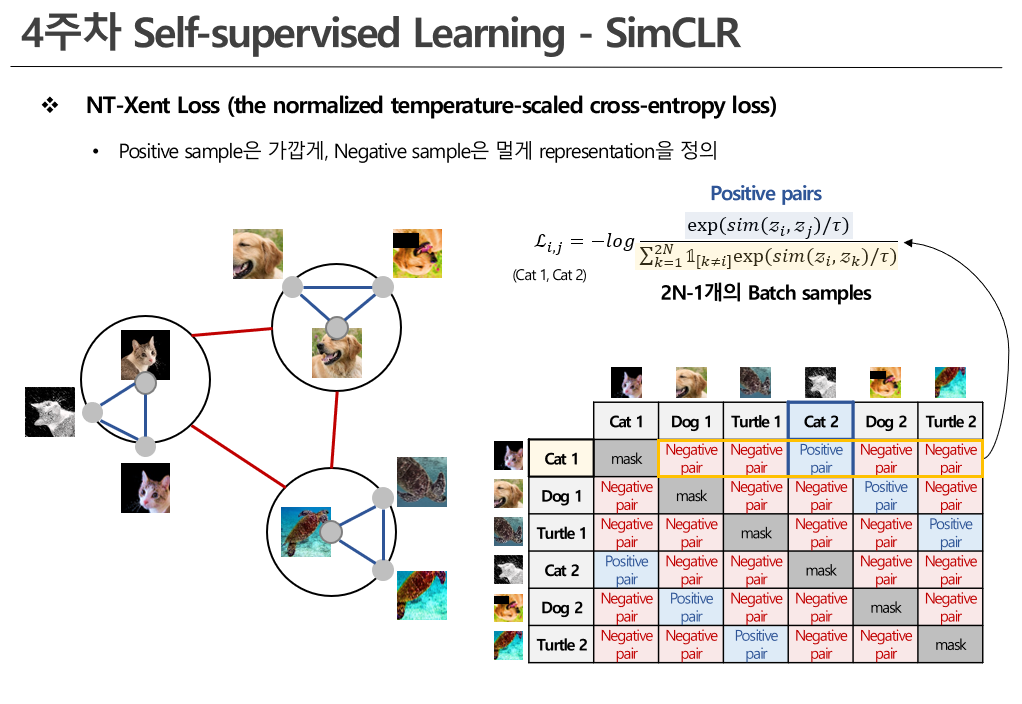

In [53]:
Image('images/InfoNCE1.PNG')

In [65]:
b = Z.size(0)//2
labels = torch.cat([torch.arange(b) for _ in range(2)], dim=0)  # 각 샘플의 label 생성

# label matrix 생성:
## 같은 원본 샘플에서 나온 positive pair는 1, 그렇지 않은 negative pair는 0인 매트릭스 생성
labels = (labels.unsqueeze(0) == labels.unsqueeze(1)).float(); labels

tensor([[1., 0., 0., 0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0., 0., 0., 1.],
        [1., 0., 0., 0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0., 0., 0., 1.]])

In [66]:
# 코사인 유사도 계산
## 벡터를 L2 정규화 후 내적
Z = F.normalize(Z, dim=1)
similarity_matrix = torch.matmul(Z, Z.T); similarity_matrix

tensor([[1.0000, 0.8860, 0.9235, 0.9157, 0.9118, 0.8475, 0.8765, 0.9017],
        [0.8860, 1.0000, 0.8703, 0.8915, 0.8550, 0.7346, 0.7669, 0.9102],
        [0.9235, 0.8703, 1.0000, 0.9242, 0.8874, 0.8413, 0.8884, 0.9287],
        [0.9157, 0.8915, 0.9242, 1.0000, 0.9201, 0.8437, 0.8948, 0.9418],
        [0.9118, 0.8550, 0.8874, 0.9201, 1.0000, 0.8535, 0.8793, 0.8977],
        [0.8475, 0.7346, 0.8413, 0.8437, 0.8535, 1.0000, 0.9209, 0.7971],
        [0.8765, 0.7669, 0.8884, 0.8948, 0.8793, 0.9209, 1.0000, 0.8512],
        [0.9017, 0.9102, 0.9287, 0.9418, 0.8977, 0.7971, 0.8512, 1.0000]],
       grad_fn=<MmBackward0>)

In [56]:
# 자기 자신과의 비교 제거 (대각 요소)
# -> labels matrix, similarity matrix에서 main diagonal 지우기
mask = torch.eye(labels.size(0), dtype=torch.bool); mask

tensor([[ True, False, False, False, False, False, False, False],
        [False,  True, False, False, False, False, False, False],
        [False, False,  True, False, False, False, False, False],
        [False, False, False,  True, False, False, False, False],
        [False, False, False, False,  True, False, False, False],
        [False, False, False, False, False,  True, False, False],
        [False, False, False, False, False, False,  True, False],
        [False, False, False, False, False, False, False,  True]])

In [67]:
labels = labels[~mask].view(labels.size(0), -1)
similarity_matrix = similarity_matrix[~mask].view(similarity_matrix.size(0), -1)
print(labels, '\n', similarity_matrix)

tensor([[0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0.]]) 
 tensor([[0.8860, 0.9235, 0.9157, 0.9118, 0.8475, 0.8765, 0.9017],
        [0.8860, 0.8703, 0.8915, 0.8550, 0.7346, 0.7669, 0.9102],
        [0.9235, 0.8703, 0.9242, 0.8874, 0.8413, 0.8884, 0.9287],
        [0.9157, 0.8915, 0.9242, 0.9201, 0.8437, 0.8948, 0.9418],
        [0.9118, 0.8550, 0.8874, 0.9201, 0.8535, 0.8793, 0.8977],
        [0.8475, 0.7346, 0.8413, 0.8437, 0.8535, 0.9209, 0.7971],
        [0.8765, 0.7669, 0.8884, 0.8948, 0.8793, 0.9209, 0.8512],
        [0.9017, 0.9102, 0.9287, 0.9418, 0.8977, 0.7971, 0.8512]],
       grad_fn=<ViewBackward0>)


In [75]:
# positive pair 분리
positives = similarity_matrix[labels.bool()].view(labels.size(0), -1); positives

tensor([[0.9118],
        [0.7346],
        [0.8884],
        [0.9418],
        [0.9118],
        [0.7346],
        [0.8884],
        [0.9418]], grad_fn=<ViewBackward0>)

In [76]:
# negative pair 분리
negatives = similarity_matrix[~labels.bool()].view(labels.size(0), -1); negatives

tensor([[0.8860, 0.9235, 0.9157, 0.8475, 0.8765, 0.9017],
        [0.8860, 0.8703, 0.8915, 0.8550, 0.7669, 0.9102],
        [0.9235, 0.8703, 0.9242, 0.8874, 0.8413, 0.9287],
        [0.9157, 0.8915, 0.9242, 0.9201, 0.8437, 0.8948],
        [0.8550, 0.8874, 0.9201, 0.8535, 0.8793, 0.8977],
        [0.8475, 0.8413, 0.8437, 0.8535, 0.9209, 0.7971],
        [0.8765, 0.7669, 0.8948, 0.8793, 0.9209, 0.8512],
        [0.9017, 0.9102, 0.9287, 0.8977, 0.7971, 0.8512]],
       grad_fn=<ViewBackward0>)

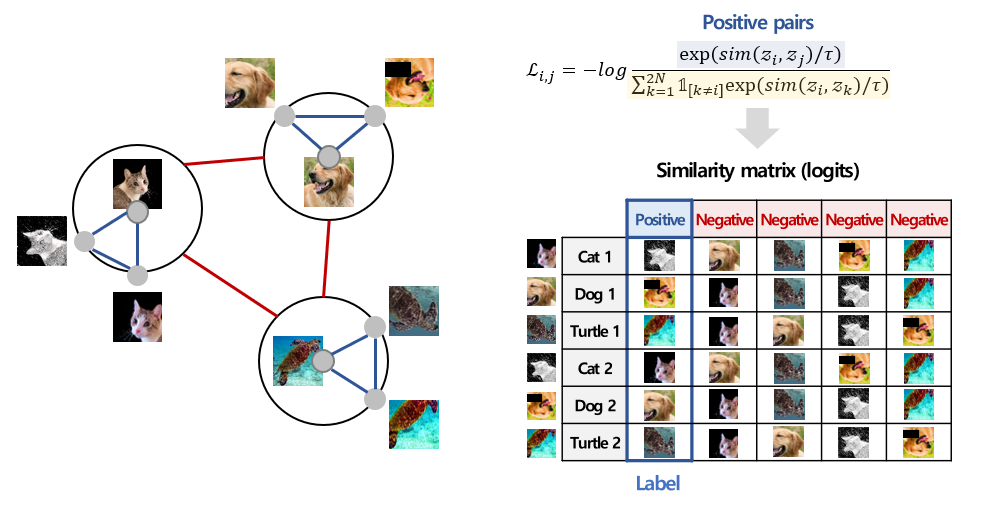

In [98]:
Image('./images/InfoNCE2.PNG')

In [77]:
# positive와 negative 샘플을 결합해서 Logits 생성
logits = torch.cat([positives, negatives], dim=1); logits

tensor([[0.9118, 0.8860, 0.9235, 0.9157, 0.8475, 0.8765, 0.9017],
        [0.7346, 0.8860, 0.8703, 0.8915, 0.8550, 0.7669, 0.9102],
        [0.8884, 0.9235, 0.8703, 0.9242, 0.8874, 0.8413, 0.9287],
        [0.9418, 0.9157, 0.8915, 0.9242, 0.9201, 0.8437, 0.8948],
        [0.9118, 0.8550, 0.8874, 0.9201, 0.8535, 0.8793, 0.8977],
        [0.7346, 0.8475, 0.8413, 0.8437, 0.8535, 0.9209, 0.7971],
        [0.8884, 0.8765, 0.7669, 0.8948, 0.8793, 0.9209, 0.8512],
        [0.9418, 0.9017, 0.9102, 0.9287, 0.8977, 0.7971, 0.8512]],
       grad_fn=<CatBackward0>)

In [96]:
# labels은 0으로 설정 (logits의 첫 번째 '열'이 positive pair, 즉 0의 label을 가지게 됨)
labels = torch.zeros(logits.shape[0], dtype=torch.long); labels

tensor([0, 0, 0, 0, 0, 0, 0, 0])

In [95]:
# logits 값을 temperature를 통해 scaling 수행 (분포를 조절하기 위함)
temperature = 0.1  # 값이 낮을 수록 entropy를 낮춤 (유사도 차이를 극단적으로 만듦; 0~1 사이의 값)
logits = logits / temperature
logits

tensor([[18.2356, 17.7190, 18.4696, 18.3148, 16.9500, 17.5299, 18.0338],
        [14.6910, 17.7190, 17.4069, 17.8309, 17.1003, 15.3389, 18.2041],
        [17.7683, 18.4696, 17.4069, 18.4846, 17.7472, 16.8259, 18.5743],
        [18.8363, 18.3148, 17.8309, 18.4846, 18.4028, 16.8738, 17.8952],
        [18.2356, 17.1003, 17.7472, 18.4028, 17.0707, 17.5856, 17.9538],
        [14.6910, 16.9500, 16.8259, 16.8738, 17.0707, 18.4182, 15.9423],
        [17.7683, 17.5299, 15.3389, 17.8952, 17.5856, 18.4182, 17.0230],
        [18.8363, 18.0338, 18.2041, 18.5743, 17.9538, 15.9424, 17.0230]],
       grad_fn=<DivBackward0>)

##### 질문. Temperature Scaling은 왜 필요할까?
- temperature 값은 softmax 함수의 출력 분포를 조절하는데, temperature 값이 1에 가까워질 수록 uniform 분포에 가까워지고, 1보다 작으면 더 뾰족한 분포 (엔트로피가 낮아지는) 형태가 됨
    - 일반적으로 0.1에서 1.0 사이의 값을 사용
- 즉, 낮은 temperature 값은 모델이 더 확신을 가지고 예측하도록 유도하고, 높은 temperature 값은 모델이 더 불확실한 예측을 하도록 유도
    - 낮은 temperature 값을 사용하면 어려운 negative sample에 더 집중하게 만들어 학습을 효과적으로 만듦
- 데이터셋과 태스크에 따라 최적의 값이 달라질 수 있음! (성능에 큰 영향을 미치는 요인)

In [97]:
# negative log likelihood = -logP(y|x)
torch.softmax(logits, dim=1)

tensor([[0.1808, 0.1079, 0.2285, 0.1957, 0.0500, 0.0893, 0.1478],
        [0.0094, 0.1940, 0.1420, 0.2170, 0.1045, 0.0180, 0.3151],
        [0.1067, 0.2153, 0.0744, 0.2185, 0.1045, 0.0416, 0.2390],
        [0.2603, 0.1545, 0.0952, 0.1831, 0.1687, 0.0366, 0.1016],
        [0.2125, 0.0683, 0.1304, 0.2512, 0.0663, 0.1109, 0.1603],
        [0.0119, 0.1143, 0.1010, 0.1059, 0.1290, 0.4962, 0.0417],
        [0.1604, 0.1264, 0.0141, 0.1821, 0.1336, 0.3072, 0.0761],
        [0.2957, 0.1326, 0.1572, 0.2276, 0.1224, 0.0164, 0.0482]],
       grad_fn=<SoftmaxBackward0>)

----------

## 3-2. SupCon 모델 정의

In [7]:
class SupCon(nn.Module):
    def __init__(self, configs):
        super(SupCon, self).__init__()
        self.configs = configs
        self.device = configs['device']

        self.backbone = configs['backbone']
        self.hidden_dim = configs['hidden_dim']
        self.projection_dim = configs['projection_dim']

        ## Base encoder 선정
        # load model from torchvision.models without pretrained weights.
        resnet_dict = {
            'resnet18': models.resnet18(pretrained=False),   
            'resnet50': models.resnet50(pretrained=False)
        }
        self.encoder = resnet_dict[self.backbone]

        # Customize for CIFAR10. Replace conv 7z7 with conv 3x3, and remove first max pooling
        self.encoder.conv1 = nn.Conv2d(in_channels=3,
                                       out_channels=64, 
                                       kernel_size=3, 
                                       stride=1, 
                                       padding=1, 
                                       bias=False)
        
        self.encoder.maxpool = nn.Identity()  # 입력과 동일한 tensor를 출력으로 내보내주는 layer

        """get feature dim from in_features in fc-layer for resnet18 in torchvision"""
        feature_dim = self.encoder.fc.in_features  # resnet18.fc.in_features=256
        self.encoder.fc = nn.Identity()  # remove final fully connected layer

        # Add MLP projection
        self.projector = nn.Sequential(
            nn.Linear(feature_dim, self.hidden_dim), 
            nn.ReLU(),
            nn.Linear(self.hidden_dim, self.projection_dim)
        )

    def forward(self, X, y):
        representation = self.encoder(X)
        projection = self.projector(representation)

        loss = self.supcon_loss(projection, y)

        return loss
    
    def supcon_loss(self, Z, 
                    labels: torch.LongTensor=None):   # 실제 label 정보를 사용!
        
        # Define appropriate labels for n_views
        labels = torch.cat([labels, labels], dim=0).view(-1, 1)
        # torch.eq로 tensor 요소를 비교. label이 같으면 True(1), 다르면 False(0)
        mask = torch.eq(labels, labels.T).float().to(self.device) 

        # Mask-out self-contrast cases (diagonal이 0인 matrix)
        logits_mask = torch.scatter(
            torch.ones_like(mask), # Returns a tensor filled with the scalar value 1, with the same size as 'mask'
            dim=1,
            index=torch.arange(len(labels)).view(-1, 1).to(device=self.device),
            value=0)
        
        ### Augmentation 및 다른 객체 동일 label만 1로 표시
        mask = mask * logits_mask # diagonal part 0으로

        # 벡터를 L2 정규화 후 내적 = 코사인 유사도
        Z = F.normalize(Z, p=2, dim=1)
        similarity_matrix = torch.matmul(Z, Z.T) # Compute logits
        # temperature scaling
        similarity_matrix.div_(self.configs['temperature'])

        # Logits scaling - For numerical stability
        logits_max, _ = torch.max(similarity_matrix, dim=1, keepdim=True)
        logits = similarity_matrix - logits_max.detach()

        # Compute log probability
        exp_logits = torch.exp(logits) * logits_mask ### InfoNCE 분모 연산: 자기 자신을 제외한 모든 객체 반영
        log_prob = logits - torch.log(exp_logits.sum(1, keepdim=True))  ### InfoNCE: 분자/분모

        # Compute mean of log-likelihood over positive
        mean_log_prob_pos = (mask * log_prob).sum(1) / mask.sum(1) ### InfoNCE에서 Positive만 분모에 들어가야함! (필터링)

        # Supervised Contrastive Loss (SCL)
        loss = - mean_log_prob_pos.mean()

        return loss

### Supervised Contrastive Loss 뜯어보기

In [8]:
data_configs = {'data_dir':'./data/'}
Cifar10 = CIFAR10Dataset(data_configs, aug_generator)
Cifar10_aug_dataset = Cifar10.get_pretrain_dataset()

img_list, labels = next(iter(DataLoader(Cifar10_aug_dataset, batch_size=3)))  # labeels도 반환
img = torch.cat(img_list, dim=0)

model_configs = {'device':'cuda',
                 'backbone':'resnet18',
                 'hidden_dim': 512,
                 'projection_dim':128}
supcon = SupCon(model_configs)

H = supcon.encoder(img)
Z = supcon.projector(H)

Files already downloaded and verified


In [ ]:
labels  # -> class가 들어가 있음

tensor([6, 9, 9])

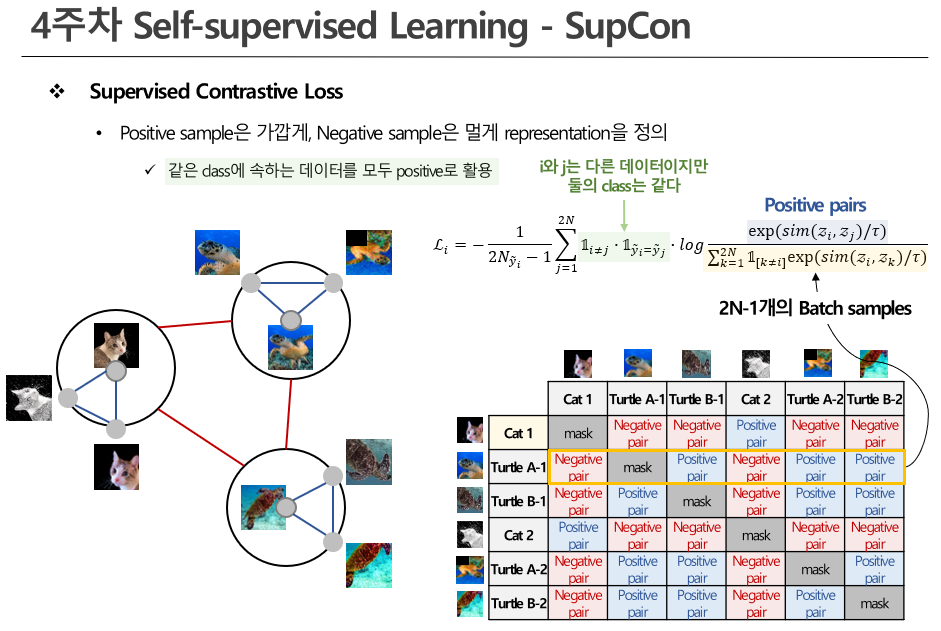

In [ ]:
Image('images/SupCon.PNG')

In [ ]:
labels = torch.cat([labels, labels], dim=0).view(-1, 1); labels

tensor([[6],
        [9],
        [9],
        [6],
        [9],
        [9]])

In [ ]:
# positive pair!
mask = torch.eq(labels, labels.T).float(); mask

tensor([[1., 0., 0., 1., 0., 0.],
        [0., 1., 1., 0., 1., 1.],
        [0., 1., 1., 0., 1., 1.],
        [1., 0., 0., 1., 0., 0.],
        [0., 1., 1., 0., 1., 1.],
        [0., 1., 1., 0., 1., 1.]])

In [ ]:
# 자기 자신은 positive로 정의하지 않음! 따라서 대각 성분은 masking을 씌워주어야 함
logits_mask = torch.scatter(torch.ones_like(mask), dim=1, 
                            index=torch.arange(len(labels)).view(-1, 1),
                            value=0
                            )
logits_mask

tensor([[0., 1., 1., 1., 1., 1.],
        [1., 0., 1., 1., 1., 1.],
        [1., 1., 0., 1., 1., 1.],
        [1., 1., 1., 0., 1., 1.],
        [1., 1., 1., 1., 0., 1.],
        [1., 1., 1., 1., 1., 0.]])

In [ ]:
mask = mask * logits_mask
mask

tensor([[0., 0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 1., 1.],
        [0., 1., 0., 0., 1., 1.],
        [1., 0., 0., 0., 0., 0.],
        [0., 1., 1., 0., 0., 1.],
        [0., 1., 1., 0., 1., 0.]])

In [ ]:
Z = F.normalize(Z, p=2, dim=1)
similarity_matrix = torch.matmul(Z, Z.T); similarity_matrix

tensor([[1.0000, 0.8462, 0.9128, 0.9020, 0.9169, 0.8309],
        [0.8462, 1.0000, 0.8275, 0.9166, 0.8437, 0.9095],
        [0.9128, 0.8275, 1.0000, 0.9030, 0.9223, 0.8085],
        [0.9020, 0.9166, 0.9030, 1.0000, 0.8875, 0.8904],
        [0.9169, 0.8437, 0.9223, 0.8875, 1.0000, 0.8103],
        [0.8309, 0.9095, 0.8085, 0.8904, 0.8103, 1.0000]],
       grad_fn=<MmBackward0>)

In [ ]:
# temperature scaling
temperature = 0.5
similarity_matrix.div_(temperature)

tensor([[2.0000, 1.6923, 1.8256, 1.8041, 1.8338, 1.6619],
        [1.6923, 2.0000, 1.6549, 1.8333, 1.6874, 1.8190],
        [1.8256, 1.6549, 2.0000, 1.8060, 1.8446, 1.6170],
        [1.8041, 1.8333, 1.8060, 2.0000, 1.7751, 1.7807],
        [1.8338, 1.6874, 1.8446, 1.7751, 2.0000, 1.6205],
        [1.6619, 1.8190, 1.6170, 1.7807, 1.6205, 2.0000]],
       grad_fn=<DivBackward0>)

In [ ]:
# similarity matrix에서 각 샘플 별로 max 값을 반환
logits_max = torch.max(similarity_matrix, dim=1, keepdim=True)[0]
logits_max

tensor([[2.0000],
        [2.0000],
        [2.0000],
        [2.0000],
        [2.0000],
        [2.0000]], grad_fn=<MaxBackward0>)

In [ ]:
### Logit scaling!
# 학습 안정성을 위해 Logit 안정화 --> 내적이기에, 차원이 클수록 매우 커지는 것을 방지
logits = similarity_matrix - logits_max.detach()
logits

tensor([[ 0.0000, -0.3076, -0.1744, -0.1959, -0.1662, -0.3381],
        [-0.3077,  0.0000, -0.3451, -0.1667, -0.3126, -0.1810],
        [-0.1744, -0.3451,  0.0000, -0.1940, -0.1554, -0.3830],
        [-0.1959, -0.1667, -0.1940,  0.0000, -0.2249, -0.2193],
        [-0.1662, -0.3126, -0.1554, -0.2249,  0.0000, -0.3795],
        [-0.3381, -0.1810, -0.3830, -0.2193, -0.3795,  0.0000]],
       grad_fn=<SubBackward0>)

#### 질문. 왜 logit scaling이 필요할까?
- 각 클래스 간의 상대적인 logit 차이는 유지되면서도 (softmax 확률은 변하지 않음), 학습 안정성 개선
- 학습 안정성:
    1) 지수 함수의 오버플로우 방지
        - softmax 계산 시 e^x 형태의 지수 함수를 사용. 이때 컴퓨터에서 표현할 수 있는 최대 수를 초과할 가능성이 있음
    2) Gradient 소실 문제 완화
        - logit 값이 클 경우 softmax 출력이 1에 가까워지는데, 이렇게 높은 확신을 가지고 예측할 시 gradient가 매우 작아져서 모델이 더 이상 효과적으로 학습하지 못하게 됨

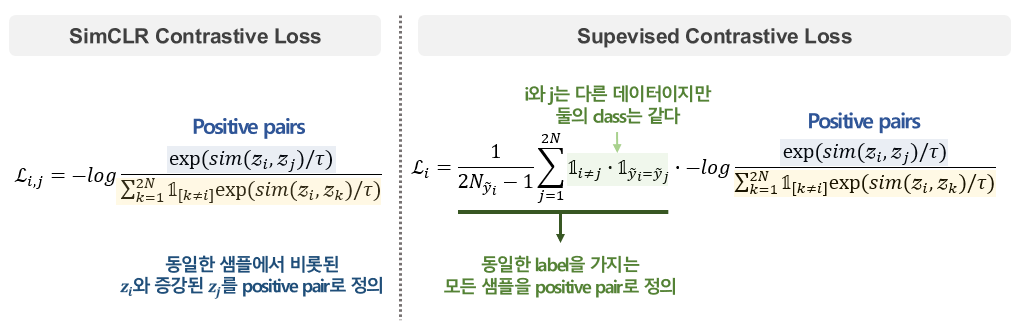

In [ ]:
Image('./images/contrastive_loss.PNG')

In [ ]:
"""분모 계산"""
exp_logits = torch.exp(logits) * logits_mask  # (e^0=1이므로 다시 한 번 대각성분을 0으로 만들어줌)
exp_logits

tensor([[0.0000, 0.7352, 0.8399, 0.8221, 0.8469, 0.7131],
        [0.7352, 0.0000, 0.7082, 0.8464, 0.7315, 0.8344],
        [0.8399, 0.7082, 0.0000, 0.8236, 0.8561, 0.6818],
        [0.8221, 0.8464, 0.8236, 0.0000, 0.7986, 0.8031],
        [0.8469, 0.7315, 0.8561, 0.7986, 0.0000, 0.6842],
        [0.7131, 0.8344, 0.6818, 0.8031, 0.6842, 0.0000]],
       grad_fn=<MulBackward0>)

In [ ]:
"""log(exp(logits) / sum(exp(logits)))를 계산: log-softmax"""
log_prob = logits - torch.log(exp_logits.sum(dim=1, keepdim=True))  # log 성질을 이용해 나눗셈을 뺄셈으로 계산
log_prob

tensor([[-1.3755, -1.6832, -1.5499, -1.5715, -1.5417, -1.7136],
        [-1.6572, -1.3496, -1.6946, -1.5163, -1.6622, -1.5306],
        [-1.5379, -1.7085, -1.3634, -1.5575, -1.5189, -1.7465],
        [-1.6054, -1.5762, -1.6035, -1.4095, -1.6344, -1.6288],
        [-1.5316, -1.6780, -1.5208, -1.5903, -1.3654, -1.7449],
        [-1.6509, -1.4938, -1.6959, -1.5321, -1.6923, -1.3128]],
       grad_fn=<SubBackward0>)

In [ ]:
"""Compute mean of log-likelihood over positive"""

# step 1. positive pair에 대해서만 log probability를 선택
mask * log_prob

# step 2. 각 샘플에 대해 positive pairs의 log probability의 합을 계산
(mask * log_prob).sum(1)

# step 3. 각 샘플의 positive pair 개수로 나누어 평균을 구함
### 이때 positive pairs 개수가 0인 경우를 고려하여, 아주 작은 (1e-9) 값을 더해서 0으로 나누는 것 방지
mean_log_prob_pos = (mask * log_prob).sum(1) / (mask.sum(1) + 1e-9)
mean_log_prob_pos

tensor([-1.5715, -1.6291, -1.6579, -1.6054, -1.6479, -1.6273],
       grad_fn=<DivBackward0>)

In [ ]:
# 최적화 목적: mean_log_prob_pos (positive pair 간의 유사도)를 최대화 하는 것
# <=> 기존 값에 음수를 취함으로써, gradient의 방향이 mean_log_prob_pos를 증가시키는 방향으로 업데이트 되게 함
# (mean_log_prob_pos를 최대화 하는 것은 -mean_log_prob_pos를 최소화 하는 것과 동일)
loss = (-mean_log_prob_pos).mean()
loss

tensor(1.6232, grad_fn=<MeanBackward0>)

-------

## 4. 모델 학습

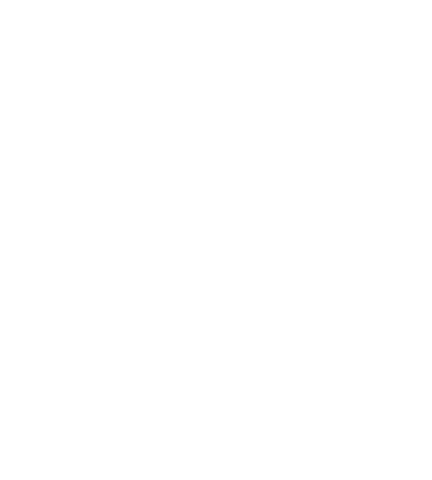

In [99]:
Image('./images/SimCLR_train.gif')

### 모델 성능 평가 지표 정의

In [8]:
def accuracy(output: torch.FloatTensor,
             target: torch.LongTensor,
             topk: tuple=(1, )):
    
    ### max_k기준 correct 여부 판별
    with torch.no_grad():
        max_k = max(topk) 
        batch_size = target.size(0) 
        _, pred = output.topk(max_k, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred)) ### eq: 동일여부 판별

        ### 확인하고 싶은 topk 지표들을 모두 산출 
        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        
        return res

### Loss Function 정의

In [9]:
criterion = nn.CrossEntropyLoss()

### Optimizer 정의

In [10]:
def get_optimizer(configs, model):
    if configs['optimizer'] == "sgd":
        optimizer = torch.optim.SGD(params=model.parameters(), lr=configs['lr'],
                              momentum=configs['momentum'], weight_decay=configs['weight_decay'])

    elif configs['optimizer'] == "adam":
        optimizer = torch.optim.Adam(params=model.parameters(), lr=configs['lr'], 
                                    betas=(configs['momentum'], 0.999), # (momentum, adaptive lr momentum)
                                    weight_decay=configs['weight_decay'])
    else:
        print("Invalid optimizer name, it should be one of ['sgd', 'adam']. Exiting...")
        exit()

    return optimizer

### 모델 학습 추세 시각화 함수 정의

In [11]:
def visualize_model_training(epoch_history, acc=True):
    # Loss 추세 시각화
    sns.lineplot(x=range(1, len(epoch_history['loss'])+1), y=epoch_history['loss'], label="Pretrain Loss")
    plt.title("Pretrain Loss Graph")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc="best")
    plt.show()

    # 성능(Accuracy) 추세 시각화
    if acc:
        sns.lineplot(x=range(1, len(epoch_history['top1_acc'])+1), y=epoch_history['top1_acc'], label="Top1 Accuracy")
        sns.lineplot(x=range(1, len(epoch_history['top5_acc'])+1), y=epoch_history['top5_acc'], label="Top5 Accuracy")
        plt.title("Top1 and Top5 Accuracy Graph")
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend(loc="best")
        plt.show();

### 사전학습 과정 함수화

In [12]:
def pretrain(device, model, pretrain_loader, criterion, optimizer):
    model.train()
    num_iterations = len(pretrain_loader)
    pretrain_history = {'loss': torch.zeros(num_iterations),       # 모델의 손실을 기록하기 위한 변수
                        'top1_acc': torch.zeros(num_iterations),
                        'top5_acc': torch.zeros(num_iterations),}   # 모델의 성능(accuracy)을 기록하기 위한 변수

    for i, batch in enumerate(pretrain_loader):
        """사전학습 단계에서는 X 데이터만 batch로 받을 수 있음! (y는 없음)"""
        # 2 * Batch Size (2는 n_views, 즉 augmentation 횟수)
        X = torch.cat(batch[0], dim=0) # [2*B, 3, 32, 32]
        X = X.to(device)

        # forward
        logits, labels = model(X)

        # Loss 계산!
        loss = criterion(logits, labels)

        """계산된 loss에서 gradient를 계산하는 역전파 함수: .backward()"""
        loss.backward()  # PyTorch 자동 미분

        """optimizer를 이용한 파라미터 업데이트"""
        optimizer.step()
        
        """Optimizer Gradient 초기화"""
        optimizer.zero_grad()

        # 모델 성능 계산
        top1, top5 = accuracy(logits, labels, topk=(1, 5))

        pretrain_history['loss'][i] = loss.item()
        pretrain_history['top1_acc'][i] = top1[0]
        pretrain_history['top5_acc'][i] = top5[0]

    pretrain_history = {k: v.mean().item() for k, v in pretrain_history.items()}

    return pretrain_history

In [13]:
def supcon_pretrain(device, model, pretrain_loader, optimizer):
    model.train()
    num_iterations = len(pretrain_loader)
    pretrain_history = {'loss': torch.zeros(num_iterations)} # 모델의 손실을 기록하기 위한 변수

    for i, batch in enumerate(pretrain_loader):
        """사전학습 단계에서는 X 데이터만 batch로 받을 수 있음! (y는 없음)"""
        # 2 * Batch Size (2는 n_views, 즉 augmentation 횟수)
        X = torch.cat(batch[0], dim=0).to(device) # [2*B, 3, 32, 32]
        y = batch[1].to(device)

        # forward
        loss = model(X, y)

        """계산된 loss에서 gradient를 계산하는 역전파 함수: .backward()"""
        loss.backward()  # PyTorch 자동 미분

        """optimizer를 이용한 파라미터 업데이트"""
        optimizer.step()
        
        """Optimizer Gradient 초기화"""
        optimizer.zero_grad()

        pretrain_history['loss'][i] = loss.item()

    pretrain_history = {k: v.mean().item() for k, v in pretrain_history.items()}

    return pretrain_history

### `main()` 함수를 통한 학습 수행

In [14]:
# 똑같은 결과를 얻기 위한 시드 고정
def set_seed(seed:int=0):
    torch.manual_seed(seed) # torch cpu seed 고정
    torch.cuda.manual_seed(seed) # torch gpu seed 고정
    torch.cuda.manual_seed_all(seed) # torch multi-gpu seed 고정
    # CUDA randomness
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    np.random.seed(seed) # numpy seed 고정
    random.seed(seed)    # python seed 고정
    os.environ['PYTHONHASHSEED'] = str(seed)

In [15]:
def simclr_main(configs):
    """Step 1: 학습 전 세팅: device, seed, configs 확인, data 정의, model 정의, loss function 및 optimizer 정의"""
    device = configs['device']  # Device 정의
    set_seed(configs['seed'])   # seed 정의

    # 우리가 설정한 하이퍼파라미터가 무엇인지 프린트하여 확인
    print(f"Configurations: \n {configs}")

    # 학습 결과를 저장할 경로 설정
    save_dir = os.path.join(configs['save_dir'], 'Pretrain')
    # make checkpoint directory
    if not os.path.exists(save_dir):
        os.makedirs(save_dir, exist_ok=True)

    ### 데이터셋 정의
    dataset = CIFAR10Dataset(configs, aug_generator)
    pretrain_dataset = dataset.get_pretrain_dataset(n_views=2)
    pretrain_loader = DataLoader(
        dataset=pretrain_dataset,
        batch_size=configs['batch_size'],
        shuffle=True,
        num_workers=0,
        drop_last=False
    )

    ### Model Architecture 정의
    model = SimCLR(configs)
    model, criterion = model.to(device), nn.CrossEntropyLoss().to(device)

    ### optimizer
    optimizer = get_optimizer(configs, model)
    lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer=optimizer,
        T_max=configs['num_epochs'],
        eta_min=configs['lr']*1e-2
    )

    # Pretraining
    epoch_history = {'loss': [],
                     'top1_acc': [], 'top5_acc': []}
    
    start = time.time()

    """Step 2: 사전학습 시작"""
    for epoch in range(1, configs['num_epochs']+1):
        print('-'*15, f'Epoch: {epoch}', '-'*15)

        pretrain_result = pretrain(device, model, pretrain_loader, criterion, optimizer)

        """Lr scheduler: Warmup for the first 10 epochs"""
        if epoch >=10:
            lr_scheduler.step()

        print(f"Loss: {pretrain_result['loss']:.2f} | Acc1: {pretrain_result['top1_acc']:.2f} | Acc5: {pretrain_result['top5_acc']:.2f}")

        """Step 3: 학습 중 도출된 loss 및 acc 값들 저장"""
        epoch_history['loss'].append(pretrain_result['loss'])
        epoch_history['top1_acc'].append(pretrain_result['top1_acc'])
        epoch_history['top5_acc'].append(pretrain_result['top5_acc'])

    """last epoch에서 checkpoint 저장"""
    torch.save(model.encoder.state_dict(), os.path.join(save_dir, 'pretrained_SimCLR.pt'))

    ## 학습 추세 시각화
    if configs['visualize']:
        visualize_model_training(epoch_history)

    # 사전학습에 소요된 시간 계산 후 출력
    end_sec = time.time() - start
    end_min = end_sec / 60
    print(f"Total Training Time: {end_min:.2f} minutes")

    return model

In [16]:
def supcon_main(configs):
    """Step 1: 학습 전 세팅: device, seed, configs 확인, data 정의, model 정의, loss function 및 optimizer 정의"""
    device = configs['device']  # Device 정의
    set_seed(configs['seed'])   # seed 정의

    # 우리가 설정한 하이퍼파라미터가 무엇인지 프린트하여 확인
    print(f"Configurations: \n {configs}")

    # 학습 결과를 저장할 경로 설정
    save_dir = os.path.join(configs['save_dir'], 'Pretrain')
    # make checkpoint directory
    if not os.path.exists(save_dir):
        os.makedirs(save_dir, exist_ok=True)

    ### 데이터셋 정의
    dataset = CIFAR10Dataset(configs, aug_generator)
    pretrain_dataset = dataset.get_pretrain_dataset(n_views=2)
    pretrain_loader = DataLoader(
        dataset=pretrain_dataset,
        batch_size=configs['batch_size'],
        shuffle=True,
        num_workers=0,
        drop_last=False
    )

    ### Model Architecture 정의
    model = SupCon(configs).to(device)
    
    ### optimizer
    optimizer = get_optimizer(configs, model)
    lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer=optimizer,
        T_max=configs['num_epochs'],
        eta_min=configs['lr']*1e-2
    )

    # Pretraining
    epoch_history = {'loss': []}
    
    start = time.time()

    """Step 2: 사전학습 시작"""
    for epoch in range(1, configs['num_epochs']+1):
        print('-'*15, f'Epoch: {epoch}', '-'*15)

        pretrain_result = supcon_pretrain(device, model, pretrain_loader, optimizer)

        """Lr scheduler: Warmup for the first 10 epochs"""
        if epoch >=10:
            lr_scheduler.step()

        print(f"Loss: {pretrain_result['loss']:.2f}")

        """Step 3: 학습 중 도출된 loss 값들 저장"""
        epoch_history['loss'].append(pretrain_result['loss'])

    """last epoch에서 checkpoint 저장"""
    torch.save(model.encoder.state_dict(), os.path.join(save_dir, 'pretrained_encoder.pt'))

    ## 학습 추세 시각화
    if configs['visualize']:
        visualize_model_training(epoch_history, acc=False)

    # 사전학습에 소요된 시간 계산 후 출력
    end_sec = time.time() - start
    end_min = end_sec / 60
    print(f"Total Training Time: {end_min:.2f} minutes")

    return model

Configurations: 
 {'device': device(type='cuda'), 'seed': 0, 'data_dir': './data/', 'save_dir': './results/SimCLR', 'batch_size': 256, 'backbone': 'resnet18', 'hidden_dim': 512, 'projection_dim': 128, 'temperature': 0.5, 'num_epochs': 10, 'optimizer': 'sgd', 'lr': 0.001, 'momentum': 0.9, 'weight_decay': 1e-06, 'visualize': True}
Files already downloaded and verified
--------------- Epoch: 1 ---------------
Loss: 5.83 | Acc1: 3.94 | Acc5: 10.81
--------------- Epoch: 2 ---------------
Loss: 5.54 | Acc1: 6.53 | Acc5: 17.20
--------------- Epoch: 3 ---------------
Loss: 5.47 | Acc1: 7.98 | Acc5: 19.98
--------------- Epoch: 4 ---------------
Loss: 5.43 | Acc1: 9.12 | Acc5: 22.23
--------------- Epoch: 5 ---------------
Loss: 5.39 | Acc1: 10.50 | Acc5: 24.69
--------------- Epoch: 6 ---------------
Loss: 5.36 | Acc1: 11.17 | Acc5: 26.34
--------------- Epoch: 7 ---------------
Loss: 5.34 | Acc1: 12.22 | Acc5: 27.93
--------------- Epoch: 8 ---------------
Loss: 5.32 | Acc1: 13.00 | Acc5: 2

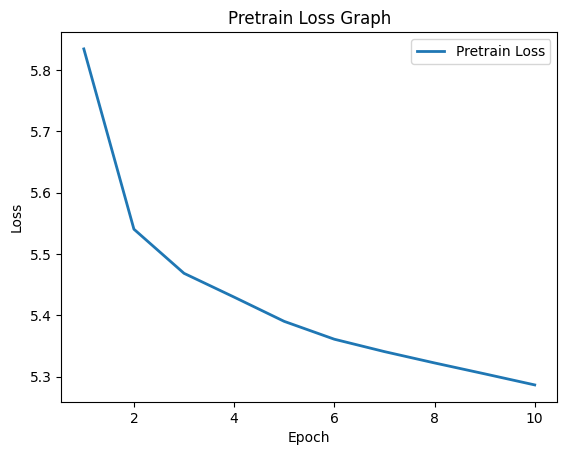

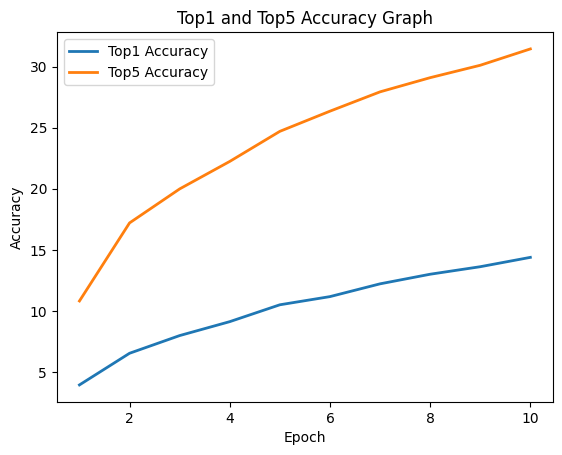

Total Training Time: 8.93 minutes


In [17]:
if __name__ == '__main__':
    configs={
        # basic setting
        'device':torch.device("cuda" if torch.cuda.is_available() else 'cpu'),
        'seed':0,

        # dataset hyperparameters
        'data_dir':'./data/',
        'save_dir':'./results/SimCLR',
        'batch_size':256,

        # model hyperparameters
        'backbone':'resnet18',
        'hidden_dim':512,
        'projection_dim':128,
        'temperature':0.5,  # see appendix B.7.: Optimal temperature under different batch sizes

        # training hyperparameters
        'num_epochs':10,
        'optimizer':'sgd',
        'lr':1e-3,
        'momentum':0.9,
        'weight_decay':1e-6,
        'visualize':True
    }
    
    simclr_encoder = simclr_main(configs)

Configurations: 
 {'device': device(type='cuda'), 'seed': 0, 'data_dir': './data/', 'save_dir': './results/SupCon', 'batch_size': 256, 'backbone': 'resnet18', 'hidden_dim': 512, 'projection_dim': 128, 'temperature': 0.5, 'num_epochs': 10, 'optimizer': 'sgd', 'lr': 0.001, 'momentum': 0.9, 'weight_decay': 1e-06, 'visualize': True}
Files already downloaded and verified
--------------- Epoch: 1 ---------------
Loss: 6.22
--------------- Epoch: 2 ---------------
Loss: 6.18
--------------- Epoch: 3 ---------------
Loss: 6.12
--------------- Epoch: 4 ---------------
Loss: 6.10
--------------- Epoch: 5 ---------------
Loss: 6.08
--------------- Epoch: 6 ---------------
Loss: 6.07
--------------- Epoch: 7 ---------------
Loss: 6.07
--------------- Epoch: 8 ---------------
Loss: 6.06
--------------- Epoch: 9 ---------------
Loss: 6.05
--------------- Epoch: 10 ---------------
Loss: 6.04


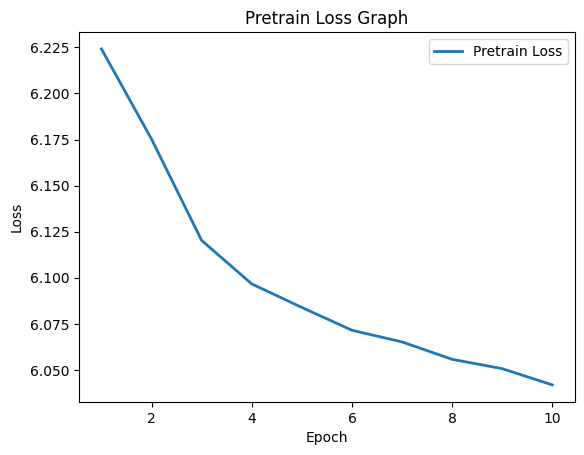

Total Training Time: 8.80 minutes


In [18]:
if __name__ == '__main__':
    configs={
        # basic setting
        'device':torch.device("cuda" if torch.cuda.is_available() else 'cpu'),
        'seed':0,

        # dataset hyperparameters
        'data_dir':'./data/',
        'save_dir':'./results/SupCon',
        'batch_size':256,

        # model hyperparameters
        'backbone':'resnet18',
        'hidden_dim':512,
        'projection_dim':128,
        'temperature':0.5,  # see appendix B.7.: Optimal temperature under different batch sizes

        # training hyperparameters
        'num_epochs':10,
        'optimizer':'sgd',
        'lr':1e-3,
        'momentum':0.9,
        'weight_decay':1e-6,
        'visualize':True
    }
    supcon_encoder = supcon_main(configs)

----------------------------------

## 5. Downstream Task

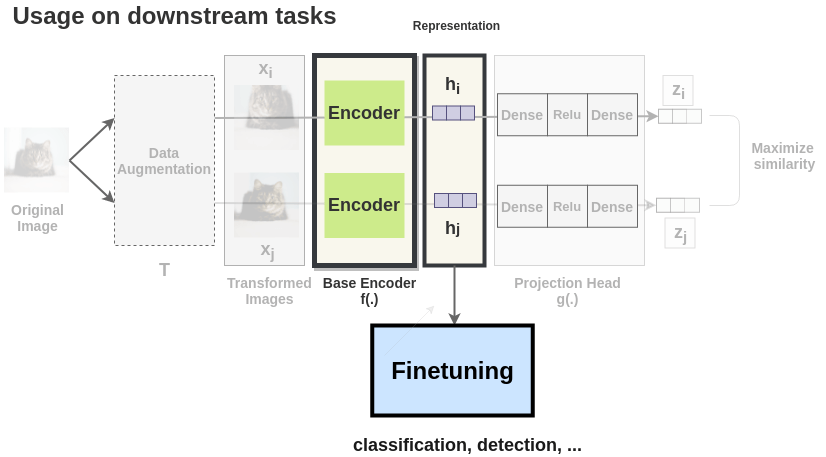

In [107]:
Image('./images/simclr-downstream.PNG')

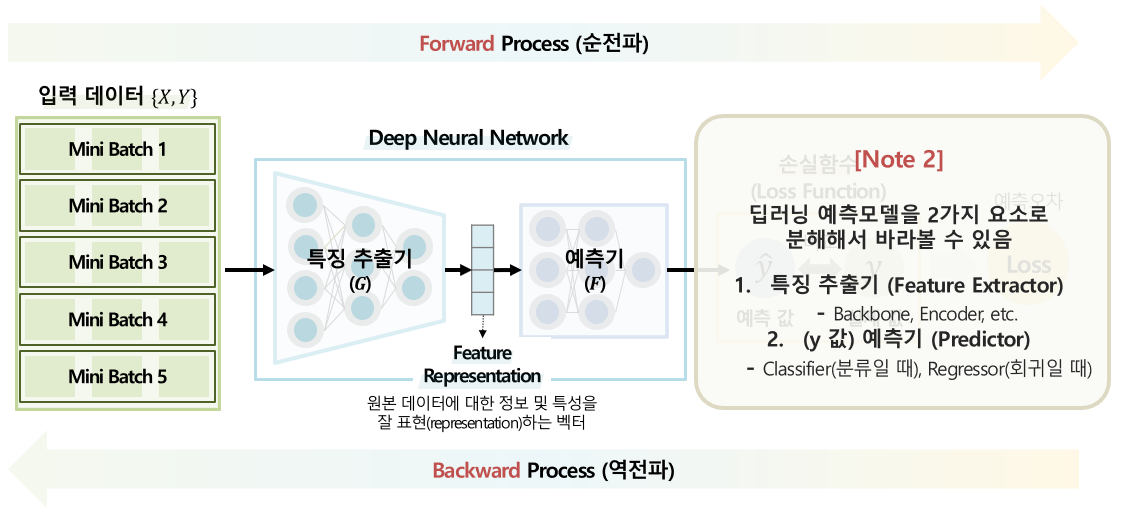

In [108]:
Image('./images/rep_remind.PNG')

### 모델 성능 평가 지표 정의

In [19]:
""" 1. 미세조정 (Downstream Task) 학습 알고리즘 정의 """
class Downstream(object):

    ### 학습에 필요한 값들 초기화
    def __init__(self, device, encoder, classifier, optimizer, **kwargs):
        self.device = device
        self.encoder = encoder.to(device)   
        self.classifier = classifier.to(device)
        self.optimizer = optimizer
        self.criterion = nn.CrossEntropyLoss().to(device)
        self.__dict__.update(kwargs)

    ### Downstream Task 학습 알고리즘
    def train_test(self, train_loader, test_loader):

        ### Train 모드 
        for epoch in range(self.epochs):
            top1_train_acc, train_loss = 0, 0
            for i, (images, targets) in enumerate(train_loader):

                ### 데이터를 Batch 단위로 불러오기
                images = images.to(self.device)
                targets = targets.to(self.device)

                ### 사전학습된 Encoder에 데이터 통과
                if self.downstream: ### Encoder Weight(사전학습된)를 학습하지 않음
                    with torch.no_grad():
                        logits = self.encoder(images)
                        logits = logits.squeeze()
                else: ### Encoder Weight를 함께 학습
                    logits = self.encoder(images)
                    logits = logits.squeeze()

                ### Classifier에 통과
                logits = self.classifier(logits)
                loss = self.criterion(logits, targets)

                ### 모델 학습
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                ### Iteration 단위(Batch) 평가 지표 산출
                top1 = accuracy(logits, targets, topk=(1, ))
                top1_train_acc += top1[0]
                
                train_loss += loss

            ### Epoch 단위(전체 학습데이터) 평가 지표 산출
            top1_train_acc /= (i + 1)
            train_loss /= (i + 1)

            ### Test 모드 
            top1_test_acc, top5_test_acc = 0, 0
            for i, (images, targets) in enumerate(test_loader):

                ### 데이터를 Batch 단위로 불러오기
                images = images.to(self.device)
                targets = targets.to(self.device)

                ### 데이터를 모델(Encoder + Classifier)에 통과
                with torch.no_grad():
                    logits = self.encoder(images)
                    logits = logits.squeeze()
                    logits = self.classifier(logits)

                ### Iteration 단위(Batch) 평가 지표 산출
                top1, top5 = accuracy(logits, targets, topk=(1, 5))
                top1_test_acc += top1[0]
                top5_test_acc += top5[0]

            ### Epoch 단위(전체 학습데이터) 평가 지표 산출
            top1_test_acc /= (i + 1)
            top5_test_acc /= (i + 1)
            
            ### Log
            print(f'Epoch: {epoch + 1} \n'
                  f'Loss: {round(train_loss.item(), 4)} \n'
                  f'Top1 Train Accuracy: {round(top1_train_acc.item(), 2)} \n'
                  f'Top1 Test Accuracy: {round(top1_test_acc.item(), 2)} \n'
                  f'Top5 Test Accuracy: {round(top5_test_acc.item(), 2)} \n')
        
        return self.encoder, self.classifier

## 사전학습 된 Encoder를 이용하여 Downstream Task 수행
- Transfer Learning(전이 학습)의 개념
- 사전학습 된 인코더를 활용하여 Supervised Learning 수행

In [20]:
""" 2. 미세조정 (Downstream Task) 수행 - Encoder Freeze (O) """
def simclr_down_main(configs: dict):
    set_seed(configs['seed'])

    ### Train 및 Test 데이터셋 정의 
    Cifar10_dataset = CIFAR10Dataset(configs, aug_generator)
    
    train_dataset = Cifar10_dataset.get_dataset(mode='train')
    test_dataset = Cifar10_dataset.get_dataset(mode='test')
    
    train_loader = DataLoader(
            dataset=train_dataset,
            batch_size=configs['batch_size'],
            shuffle=True,
            num_workers=configs['num_worker'],
            drop_last=False)
    
    test_loader = DataLoader(
            dataset=test_dataset,
            batch_size=configs['batch_size'],
            shuffle=False,
            num_workers=configs['num_worker'],
            drop_last=False)
    
    ### Model Architecture 정의
    encoder = SimCLR(configs).encoder
    ### 사전학습된 Weight 불러오기
    encoder.load_state_dict(torch.load(os.path.join(configs['save_dir'], 'pretrained_SimCLR.pt')))
    print("All keys matched successfully")

    classifier = nn.Linear(512, configs['num_class'])

    ### Optimizer 정의
    optimizer = torch.optim.Adam(
        classifier.parameters(), 
        lr=configs['learning_rate'], 
        weight_decay=configs['weight_decay'])
    
    ### Downstream Task 학습 알고리즘 정의
    downstream = Downstream(
        device = configs['device'],
        encoder=encoder,
        classifier=classifier,
        optimizer=optimizer,
        epochs=configs['epochs'],
        downstream = configs['downstream'])
    
    ### Downstream Task 학습 수행
    supervised_encoder, supervised_classifier = downstream.train_test(train_loader=train_loader,
                                                                        test_loader=test_loader)
    
    return supervised_encoder, supervised_classifier

### Main
if __name__ == '__main__':  
    configs = {'seed':0,
               'device':torch.device("cuda" if torch.cuda.is_available() else 'cpu'),
               'data_dir': './data/', 
               'save_dir':'./results/SimCLR/Pretrain',
               'downstream': True, 'batch_size': 256, 'epochs': 10, 
               'learning_rate': 5e-4, 'weight_decay':1e-4,
               'backbone': 'resnet18', 'hidden_dim': 512, 'projection_dim': 128,
               'num_class': 10, 'num_worker': 0}
    simclr_supervised_model = simclr_down_main(configs)

Files already downloaded and verified
Files already downloaded and verified
All keys matched successfully
Epoch: 1 
Loss: 2.1562 
Top1 Train Accuracy: 20.61 
Top1 Test Accuracy: 32.29 
Top5 Test Accuracy: 83.7 

Epoch: 2 
Loss: 1.8945 
Top1 Train Accuracy: 31.82 
Top1 Test Accuracy: 32.92 
Top5 Test Accuracy: 85.74 

Epoch: 3 
Loss: 1.8069 
Top1 Train Accuracy: 34.61 
Top1 Test Accuracy: 35.49 
Top5 Test Accuracy: 86.65 

Epoch: 4 
Loss: 1.7466 
Top1 Train Accuracy: 36.83 
Top1 Test Accuracy: 37.88 
Top5 Test Accuracy: 87.92 

Epoch: 5 
Loss: 1.7208 
Top1 Train Accuracy: 37.57 
Top1 Test Accuracy: 38.0 
Top5 Test Accuracy: 88.39 

Epoch: 6 
Loss: 1.6976 
Top1 Train Accuracy: 38.26 
Top1 Test Accuracy: 38.24 
Top5 Test Accuracy: 88.48 

Epoch: 7 
Loss: 1.6749 
Top1 Train Accuracy: 38.71 
Top1 Test Accuracy: 38.73 
Top5 Test Accuracy: 88.46 

Epoch: 8 
Loss: 1.6595 
Top1 Train Accuracy: 39.42 
Top1 Test Accuracy: 39.12 
Top5 Test Accuracy: 88.89 

Epoch: 9 
Loss: 1.6426 
Top1 Train Accur

In [21]:
""" 2. 미세조정 (Downstream Task) 수행 - Encoder Freeze (O) """
def supcon_down_main(configs: dict):
    set_seed(configs['seed'])

    ### Train 및 Test 데이터셋 정의 
    Cifar10_dataset = CIFAR10Dataset(configs, aug_generator)
    
    train_dataset = Cifar10_dataset.get_dataset(mode='train')
    test_dataset = Cifar10_dataset.get_dataset(mode='test')
    
    train_loader = DataLoader(
            dataset=train_dataset,
            batch_size=configs['batch_size'],
            shuffle=True,
            num_workers=configs['num_worker'],
            drop_last=False)
    
    test_loader = DataLoader(
            dataset=test_dataset,
            batch_size=configs['batch_size'],
            shuffle=False,
            num_workers=configs['num_worker'],
            drop_last=False)
    
    ### Model Architecture 정의
    encoder = SupCon(configs).encoder
    ### 사전학습된 Weight 불러오기
    encoder.load_state_dict(torch.load(os.path.join(configs['save_dir'], 'pretrained_encoder.pt')))
    print("All keys matched successfully")

    classifier = nn.Linear(512, configs['num_class'])

    ### Optimizer 정의
    optimizer = torch.optim.Adam(
        classifier.parameters(), 
        lr=configs['learning_rate'], 
        weight_decay=configs['weight_decay'])
    
    ### Downstream Task 학습 알고리즘 정의
    downstream = Downstream(
        device = configs['device'],
        encoder=encoder,
        classifier=classifier,
        optimizer=optimizer,
        epochs=configs['epochs'],
        downstream = configs['downstream'])
    
    ### Downstream Task 학습 수행
    supervised_encoder, supervised_classifier = downstream.train_test(train_loader=train_loader,
                                                                        test_loader=test_loader)
    
    return supervised_encoder, supervised_classifier

### Main
if __name__ == '__main__':  
    configs = {'seed':0,
               'device':torch.device("cuda" if torch.cuda.is_available() else 'cpu'),
               'data_dir': './data/', 
               'save_dir':'./results/SupCon/Pretrain',
               'downstream': True, 'batch_size': 256, 'epochs': 10, 
               'learning_rate': 5e-4, 'weight_decay':1e-4,
               'backbone': 'resnet18', 'hidden_dim': 512, 'projection_dim': 128,
               'num_class': 10, 'num_worker': 0}
    supcon_supervised_model = supcon_down_main(configs)

Files already downloaded and verified
Files already downloaded and verified
All keys matched successfully
Epoch: 1 
Loss: 2.2005 
Top1 Train Accuracy: 18.23 
Top1 Test Accuracy: 28.18 
Top5 Test Accuracy: 81.6 

Epoch: 2 
Loss: 1.9628 
Top1 Train Accuracy: 28.61 
Top1 Test Accuracy: 30.86 
Top5 Test Accuracy: 86.04 

Epoch: 3 
Loss: 1.8551 
Top1 Train Accuracy: 31.76 
Top1 Test Accuracy: 33.55 
Top5 Test Accuracy: 88.03 

Epoch: 4 
Loss: 1.7799 
Top1 Train Accuracy: 35.5 
Top1 Test Accuracy: 35.34 
Top5 Test Accuracy: 89.53 

Epoch: 5 
Loss: 1.7411 
Top1 Train Accuracy: 36.04 
Top1 Test Accuracy: 36.81 
Top5 Test Accuracy: 89.85 

Epoch: 6 
Loss: 1.7099 
Top1 Train Accuracy: 36.76 
Top1 Test Accuracy: 37.53 
Top5 Test Accuracy: 90.34 

Epoch: 7 
Loss: 1.6854 
Top1 Train Accuracy: 37.9 
Top1 Test Accuracy: 38.14 
Top5 Test Accuracy: 90.1 

Epoch: 8 
Loss: 1.663 
Top1 Train Accuracy: 38.59 
Top1 Test Accuracy: 37.21 
Top5 Test Accuracy: 90.58 

Epoch: 9 
Loss: 1.644 
Top1 Train Accuracy:

## [비교] Self-Supervised Learning 기법을 이용한 사전학습을 수행하지 않고, 단순히 지도학습(Supervised Learning)만 적용한 경우

In [ ]:
""" 2. 미세조정 (Downstream Task) 수행 - Encoder Freeze (O) """
def main(configs: dict):
    set_seed(configs['seed'])

    ### Train 및 Test 데이터셋 정의 
    Cifar10_dataset = CIFAR10Dataset(configs, aug_generator)
    
    train_dataset = Cifar10_dataset.get_dataset(mode='train')
    test_dataset = Cifar10_dataset.get_dataset(mode='test')
    
    train_loader = DataLoader(
            dataset=train_dataset,
            batch_size=configs['batch_size'],
            shuffle=True,
            num_workers=configs['num_worker'],
            drop_last=False)
    
    test_loader = DataLoader(
            dataset=test_dataset,
            batch_size=configs['batch_size'],
            shuffle=False,
            num_workers=configs['num_worker'],
            drop_last=False)
    
    ### Model Architecture 정의
    encoder = SimCLR(configs).encoder
    # encoder.load_state_dict(torch.load(os.path.join(configs['save_dir'], 'pretrained_SimCLR.pt')))

    classifier = nn.Linear(512, configs['num_class'])

    ### Optimizer 정의
    optimizer = torch.optim.Adam(
        classifier.parameters(), 
        lr=configs['learning_rate'], 
        weight_decay=configs['weight_decay'])
    
    ### Downstream Task 학습 알고리즘 정의
    downstream = Downstream(
        device = configs['device'],
        encoder=encoder,
        classifier=classifier,
        optimizer=optimizer,
        epochs=configs['epochs'],
        downstream = configs['downstream'])
    
    
    ### Downstream Task 학습 수행
    supervised_encoder, supervised_classifier = downstream.train_test(train_loader=train_loader,
                                                                        test_loader=test_loader)
    
    return supervised_encoder, supervised_classifier

### Main
if __name__ == '__main__':  
    configs = {'seed':0,
               'device':torch.device("cuda" if torch.cuda.is_available() else 'cpu'),
               'data_dir': './data/', 
               'downstream': False, 'batch_size': 256, 'epochs': 10, 
               'learning_rate': 5e-4, 'weight_decay':1e-4,
               'backbone': 'resnet18', 'hidden_dim': 512, 'projection_dim': 128,
               'num_class': 10, 'num_worker': 0}
    supervised_model = main(configs)

Files already downloaded and verified
Files already downloaded and verified
Epoch: 1 
Loss: 2.2962 
Top1 Train Accuracy: 13.28 
Top1 Test Accuracy: 18.16 
Top5 Test Accuracy: 62.5 

Epoch: 2 
Loss: 2.218 
Top1 Train Accuracy: 18.23 
Top1 Test Accuracy: 17.85 
Top5 Test Accuracy: 66.97 

Epoch: 3 
Loss: 2.1728 
Top1 Train Accuracy: 20.79 
Top1 Test Accuracy: 21.85 
Top5 Test Accuracy: 71.69 

Epoch: 4 
Loss: 2.1357 
Top1 Train Accuracy: 23.08 
Top1 Test Accuracy: 23.16 
Top5 Test Accuracy: 74.33 

Epoch: 5 
Loss: 2.1023 
Top1 Train Accuracy: 24.65 
Top1 Test Accuracy: 23.91 
Top5 Test Accuracy: 76.19 

Epoch: 6 
Loss: 2.0774 
Top1 Train Accuracy: 25.98 
Top1 Test Accuracy: 24.12 
Top5 Test Accuracy: 74.66 

Epoch: 7 
Loss: 2.0563 
Top1 Train Accuracy: 26.81 
Top1 Test Accuracy: 27.16 
Top5 Test Accuracy: 76.43 

Epoch: 8 
Loss: 2.0294 
Top1 Train Accuracy: 28.7 
Top1 Test Accuracy: 25.98 
Top5 Test Accuracy: 76.87 

Epoch: 9 
Loss: 2.0138 
Top1 Train Accuracy: 29.0 
Top1 Test Accuracy: 

#### **최종 성능 비교**

|   | Supervised Learning | SimCLR Downstream | SupCon Downstream |
|---| ------------------- | ----------- | --------------------- |
|Top 1 Test ACC| 25.75 | **39.15** | 38.46 | 
|Top 5 Test ACC| 77.32 | 89.95 | **90.81** |